In [1]:
import math
import random
import warnings

from hanabi_learning_environment.rl_env import Agent
import numpy as np
from enum import Enum, auto, Flag, IntFlag
import dataclasses
from dataclasses import dataclass
import functools
import itertools
import abc
from collections import defaultdict
import pprint
import queue
import collections
from multiprocessing import set_start_method, get_context
import matplotlib.pyplot as plt
from matplotlib.pyplot import Figure, Axes

from hanabi_learning_environment import rl_env
from hanabi_learning_environment.rl_env import Agent

from scipy import signal

from typing import NoReturn, Callable, Sequence, Final, Protocol, TypedDict, Literal, Union, ClassVar, List, FrozenSet, Generic, TypeVar, Set, Tuple, Callable, Iterable, Any, Dict, Iterator,Optional

from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import concurrent.futures
import multiprocessing.pool

import sys
sys.setrecursionlimit(sys.getrecursionlimit() + 5)

%matplotlib inline



rng: np.random.Generator = np.random.default_rng()

In [2]:
Color = Literal["B", "G", "R", "W", "Y"]
CardColor = Optional[Color]
Rank = Literal[0, 1, 2, 3, 4]
CardRank = Literal[-1, Rank]
ActionPD = Literal["PLAY", "DISCARD"]
ActionColor = Literal["REVEAL_COLOR"]
ActionRank = Literal["REVEAL_RANK"]

class BaseActionDict(TypedDict):
    pass

class ActionPDDict(BaseActionDict):
    action_type: ActionPD
    card_index: int

class BaseActionRevealDict(BaseActionDict):
    target_offset: int

class ActionColorDict(BaseActionRevealDict):
    action_type: ActionColor
    color: Color

class ActionRankDict(BaseActionRevealDict):
    action_type: ActionRank
    rank: Rank

def actplay(ind: int) -> ActionPDDict:
    """
    Helper method to create the appropriate dict for playing a card
    :param ind: index of card to play
    :return: an actionPDDict that plays that specified card
    """
    return {
        "action_type": "PLAY",
        "card_index": ind
    }

def actdiscard(ind: int) -> ActionPDDict:
    """
    Helper method for discarding
    :param ind: index of card being discarded
    :return: the appropriate actionPDDict
    """
    return {
        "action_type": "DISCARD",
        "card_index": ind
    }

def actcolor(offset: Union[int, "OtherInfo"], colour: Color) -> ActionColorDict:
    """
    Helper method for revealing colour
    :param offset: player to target
    :param colour: colour to reveal
    :return: the appropriate ActionColorDict
    """
    if isinstance(offset, OtherInfo):
        offset = offset.offset
    return {
        "action_type": "REVEAL_COLOR",
        "color": colour,
        "target_offset": offset
    }

class ActionRankDict(BaseActionRevealDict):
    action_type: ActionRank
    rank: Rank

def actrank(offset: Union[int, "OtherInfo"], rank: Rank) -> ActionRankDict:
    """
    Helper method for revealing rank
    :param offset: player to target
    :param rank: rank to reveal
    :return: the appropriate ActionRankDict
    """
    if isinstance(offset, OtherInfo):
        offset = offset.offset
    return {
        "action_type": "REVEAL_RANK",
        "rank": rank,
        "target_offset": offset
    }

ActionDict = Union[ActionPDDict, ActionColorDict, ActionRankDict]
Action = Union[ActionDict, int]

class HandCard(TypedDict):
    color: CardColor
    rank: CardRank

OwnHand = List[HandCard]

class KnownCard(TypedDict):
    color: Color
    rank: Rank

KnownHand = List[KnownCard]

Card = Union[HandCard, KnownCard]


@dataclass(init=False, repr=True, eq=True, frozen=True)
class CardData:
    color: CardColor
    rank: CardRank

    UNKNOWN_CARD: ClassVar["CardData"]
    VALID_RANKS: ClassVar[FrozenSet[Rank]] = frozenset((0,1,2,3,4))
    VALID_COLOR: ClassVar[FrozenSet[Color]]= frozenset(("R","G","B","Y","W"))


    def __init__(self, col: CardColor, rank: Optional[CardRank]):
        object.__setattr__(self, "color", col)
        object.__setattr__(self, "rank", -1 if rank is None else rank)

    @classmethod
    def make(cls, c: Card) -> "CardData":
        return cls(c["color"],c["rank"])

    @classmethod
    def makelist(cls, clist: Iterable[Card]) -> List["CardData"]:
        return [cls.make(c) for c in clist]

    @classmethod
    @functools.lru_cache(1)
    def UNKNOWN_CARD(cls) -> "CardData":
        return cls(None, -1)

    @classmethod
    @functools.lru_cache(1)
    def all_valid_cards(cls) -> FrozenSet["CardData"]:
        return frozenset(
            cls(c, r)
            for c in cls.VALID_COLOR
            for r in cls.VALID_RANKS
        )

    @property
    def iter_higher(self) -> Iterator["CardData"]:
        "iterate through all of the cards higher than this card in same colour"
        return (CardData(self.color, rnk) for rnk in range(self.rank +1, 5))

    @functools.cached_property
    def is_known(self) -> bool:
        "returns true if all the data on this card is known"
        return self.color is not None and self.rank != -1

    @functools.cached_property
    def is_unknown(self) -> bool:
        "returns true if everything about this card is unknown"
        return self.color is None and self.rank == -1

    def match_potential_other_known(self, crd: "CardData") -> bool:
        assert crd.is_known
        if self.is_known:
            return self == crd
        else:
            if self.color:
                return self.color == crd.color
            return self.rank == -1 or self.rank == crd.rank

    def filter_card_list(self, other_cards: Iterable["CardData"]) -> Iterable["CardData"]:
        if self.is_known:
            if self in other_cards:
                return [self]
            warnings.warn(f"card {self} not in given other card list\n{other_cards}")
            return []
        elif self.is_unknown:
            return other_cards
        elif self.color is None:
            return [crd for crd in other_cards if self.rank == crd.rank]
        return [crd for crd in other_cards if self.color == crd.color]

    def potential_matches(self, other_cards: Iterable["CardData"]) -> Iterator["CardData"]:
        if self.is_known:
            return (crd for crd in other_cards if crd == self)
        return (crd for crd in other_cards if self.match_potential_other_known(crd))





def card_to_dc(c: Card) -> CardData:
    return CardData(c["color"], c["rank"])

def cardlist_to_dc(clist: Iterable[Card]) -> List[CardData]:
    return [CardData.make(c) for c in clist]

TCard = TypeVar("TCard", bound=Card)

class FireworksDict(TypedDict):
    B: int
    G: int
    R: int
    W: int
    Y: int

FRank = Literal[0,1,2,3,4,5]

@dataclass(init=True, repr=True, eq=True, frozen=True)
class PlayableUselessFuture:
    playable: FrozenSet[CardData]
    useless:FrozenSet[CardData]
    future: FrozenSet[CardData]

    @classmethod
    def make(cls, playable: Set[CardData], useless: Set[CardData], future: Set[CardData]) -> "PlayableUselessFuture":
        return cls(
            frozenset(playable), frozenset(useless), frozenset(future)
        )

    @property
    def get_max_playable_rank(self) -> FRank:
        if not self.playable:
            return 5
        return max(self.playable, key=lambda c: c.rank).rank

@dataclass(init=True, repr=True, eq=True, frozen=True)
class FireworksData:
    B: FRank
    G: FRank
    R: FRank
    W: FRank
    Y: FRank

    def __str__(self):
        return f"fireworks- B:{self.B}, G:{self.G}, R:{self.R}, W:{self.W}, Y:{self.Y}"

    @property
    def tupled(self) -> Tuple[FRank, FRank, FRank, FRank, FRank]:
        return dataclasses.astuple(self)

    @functools.cached_property
    def dicted(self) -> Dict[Color, FRank]:
        return {
            "B": self.B,
            "G": self.G,
            "R": self.R,
            "W": self.W,
            "Y": self.Y
        }

    @functools.cached_property
    def highest_playable_cards(self) -> FrozenSet[CardData]:
        return frozenset(
            CardData(k,v) for k, v in self.dicted.items() if v == self.max_play_rank and v != 5
        )

    @functools.cached_property
    def lowest_playable_cards(self) -> FrozenSet[CardData]:

        return frozenset(
            CardData(k, v) for k, v in self.dicted.items() if v == self.min_play_rank
        )

    @functools.cached_property
    def playable_useless_future(self) -> PlayableUselessFuture:
        playable: Set["CardData"] = set()
        useless: Set["CardData"] = set()
        future: Set["CardData"] = set()
        mydict: Dict[Color, FRank] = self.dicted
        for c in CardData.all_valid_cards():
            if c.rank == mydict[c.color]:
                playable.add(c)
            elif c.rank < mydict[c.color]:
                useless.add(c)
            else:
                future.add(c)
        return PlayableUselessFuture.make(playable, useless, future)

    @property
    def used_cards(self) -> FrozenSet["CardData"]:
        return self.playable_useless_future.useless

    @functools.cached_property
    def min_play_rank(self) -> FRank:
        return min(self.tupled)

    @property
    def max_play_rank(self) -> FRank:
        return self.playable_useless_future.get_max_playable_rank

    @classmethod
    def make(cls, fworks: FireworksDict) -> "FireworksData":
        return cls(fworks["B"],fworks["G"],fworks["R"],fworks["W"],fworks["Y"])





@dataclass(init=True, repr=True, eq=True, frozen=True)
class OtherInfo:
    offset:     int
    hand:       Tuple[CardData]
    playable:   FrozenSet[int]
    unplayable: FrozenSet[int]
    saveable:   FrozenSet[int]
    endangered: FrozenSet[int]
    un_ranks:   FrozenSet[int]
    un_cols:    FrozenSet[int]

    @functools.cached_property
    def full_unknowns(self) -> FrozenSet[int]:
        return self.un_ranks.union(self.un_cols)

    @functools.cached_property
    def oldest_unknown_index(self) -> Optional[int]:
        if self.full_unknowns:
            return min(self.full_unknowns)
        return None

    @property
    def is_oldest_endangered(self) -> bool:
        return self.oldest_unknown_index in self.endangered

    @property
    def is_oldest_saveable(self) -> bool:
        return self.oldest_unknown_index in self.saveable

    @classmethod
    def make(
            cls, offset:int, real: List[CardData], known: List[CardData],
            playable: FrozenSet[CardData], useless: FrozenSet[CardData],
            endangered: FrozenSet[CardData], unique_vis: FrozenSet[CardData]
    ) -> "OtherInfo":
        pl = set()
        ul = set()
        sv = set()
        en = set()
        ur = set()
        uc = set()
        for i, crd in enumerate(known):
            if not crd.is_known:
                if crd.rank == -1:
                    ur.add(i)
                if crd.color is None:
                    uc.add(i)
                crd = real[i]
            if crd in playable:
                pl.add(i)
            elif crd in useless:
                ul.add(i)
            if crd in unique_vis:
                sv.add(i)
                if crd in endangered:
                    en.add(i)
        return OtherInfo(
            offset,
            tuple(real),
            frozenset(pl),
            frozenset(ul),
            frozenset(sv),
            frozenset(en),
            frozenset(ur),
            frozenset(uc)
        )





@dataclass(init=True, repr=True, eq=True, frozen=True)
class MyHandData:
    full_hand: List[CardData]
    possible_cards_in_hand:  Dict[CardData, List[CardData]]
    playable_cards_in_hand:  Dict[CardData, List[CardData]]
    useless_cards_in_hand:   Dict[CardData, List[CardData]]
    future_playable_in_hand: Dict[CardData, List[CardData]]
    endangered_card_in_hand: Dict[CardData, List[CardData]]



    def _prob_calculator(self, candidates: Dict[CardData, List[CardData]]) -> Dict[CardData, float]:
        return dict(
            (c, len(v)/len(self.possible_cards_in_hand[c]))
            for c, v in candidates.items()
        )

    @functools.cached_property
    def probability_hand_card_playable(self) -> Dict[CardData, float]:
        return self._prob_calculator(self.playable_cards_in_hand)
    @functools.cached_property
    def probability_hand_card_useless(self) -> Dict[CardData, float]:
        return self._prob_calculator(self.useless_cards_in_hand)
    @functools.cached_property
    def probability_hand_card_f_playable(self) -> Dict[CardData, float]:
        return self._prob_calculator(self.future_playable_in_hand)
    @functools.cached_property
    def probability_hand_card_endangered(self) -> Dict[CardData, float]:
        return self._prob_calculator(self.endangered_card_in_hand)




    @classmethod
    def make_from_obs(cls, obs: "ObservationData") -> "MyHandData":
        possible_cards_in_hand: Dict[CardData, List[CardData]] = {}
        playable_cards_in_hand: Dict[CardData, List[CardData]] = {}
        useless_cards_in_hand:  Dict[CardData, List[CardData]] = {}
        future_playable_in_hand:Dict[CardData, List[CardData]] = {}
        endangered_card_in_hand:Dict[CardData, List[CardData]] = {}
        for crd in set(obs.my_hand):
            possibles: List[crd] = crd.filter_card_list(obs.unseen)
            possible_cards_in_hand[crd] = possibles
            possible_c: int = len(possibles)
            assert possible_c > 0
            pl = []
            ul = []
            fp = []
            en = []
            for p in possibles:
                if p in obs.playable:
                    pl.append(p)
                elif p in obs.useless:
                    ul.append(p)
                elif p in obs.future_playable:
                    fp.append(p)
                if p in obs.endangered:
                    en.append(p)
            playable_cards_in_hand[crd] = pl
            useless_cards_in_hand[crd]  = ul
            future_playable_in_hand[crd]= fp
            endangered_card_in_hand[crd]= en
        return cls(
            obs.my_hand,
            possible_cards_in_hand,
            playable_cards_in_hand,
            useless_cards_in_hand,
            future_playable_in_hand,
            endangered_card_in_hand
        )

class ObservationDict(TypedDict):
    current_player: int
    current_player_offset: int
    deck_size: int
    discard_pile: List[KnownCard]
    fireworks: FireworksDict
    information_tokens: int
    legal_moves: List[ActionDict]
    life_tokens: int
    card_knowledge: List[List[Union[OwnHand, KnownHand]]]
    observed_hands: List[List[Union[OwnHand, KnownHand]]]
    num_players: int
    vectorized: List[Literal[0, 1]]


@dataclass(init=True, repr=True, eq=True, frozen=True)
class ObservationData:
    "A dataclass wrapper for the observation dict"
    deck_size: int
    "how many cards are still in the deck?"
    unseen: List[CardData]
    "All the cards that we haven't seen"
    discard: List[CardData]
    "all the discarded cards"
    fireworks: FireworksData
    "current state of fireworks"
    infos: int
    "information tokens left"
    legal_moves: List[Action]
    "legal moves that can be performed from this gamestate"
    lives: int
    "lives remaining"
    my_hand: List[CardData]
    "the cards in the player's hand"
    observed: List[List[CardData]]
    "what the player can see in the other hands"
    knowledge: List[List[CardData]]
    "what each player knows about their hands"
    future_playable: FrozenSet[CardData]
    "cards that may be playable in the future"
    playable: FrozenSet[CardData]
    "cards that are currently playable"
    useless: FrozenSet[CardData]
    "cards that can't be played"
    endangered: FrozenSet[CardData]
    "cards that aren't useless but only one instance of them exists"
    one_visible: FrozenSet[CardData]
    "cards that aren't useless but only one instance of them is visible"
    num_players: int
    "how many players are there?"
    _raw: ObservationDict
    "raw observation, may or may not be useful as a fallback"

    @property
    def can_tell(self) -> bool:
        return self.infos > 0

    @functools.cached_property
    def my_hand_dat(self) -> MyHandData:
        "Detailed stats about the player's hand"
        return MyHandData.make_from_obs(self)

    @functools.cached_property
    def others(self) -> Dict[int, OtherInfo]:
        "Detailed stats about other players"
        return dict(
            (i, OtherInfo.make(
                i,
                self.observed[i],
                self.knowledge[i],
                self.playable,
                self.useless,
                self.endangered,
                self.one_visible
            )) for i in range(1, self.num_players)
        )

    @property
    def all_others_visible(self) -> FrozenSet[CardData]:
        return frozenset(
            itertools.chain.from_iterable(
                (crd for crd in self.observed[i] if crd.is_known)
                for i in range(1, self.num_players)
            )
        )

    @staticmethod
    def individual_card_counts() -> Dict[CardData, int]:
        """How many cards are there of each type in the deck?
        Recalculated when called, makes this stored version practically immutable"""
        return dict(
            (crd, 3 if crd.rank == 0 else 1 if crd.rank == 4 else 2) for crd in CardData.all_valid_cards()
        )

    full_deck: ClassVar[Tuple[CardData]]
    "A full deck, as a classvar, for ease of use"

    def mycard_argmax(self, dat: Dict[CardData, float], threshold: float = -math.inf) -> Optional[int]:
        curmax: float = -math.inf
        max_ind: Optional[int] = None
        for ind, crd in enumerate(self.my_hand):
            if dat[crd] >= threshold and dat[crd] > curmax:
                curmax = dat[crd]
                max_ind = ind
        return max_ind

    def mycard_argmin(self, dat: Dict[CardData, float], threshold: float = math.inf) -> Optional[int]:
        curmin: float = math.inf
        min_ind: Optional[int] = None
        for ind, crd in enumerate(self.my_hand):
            if dat[crd] <= threshold and dat[crd] < curmin:
                curmin = dat[crd]
                min_ind = ind
        return min_ind



    @classmethod
    def all_unseen_useless_endangered_onevisible(
            cls, discard: List[CardData], all_visible: List[CardData], fireworks: FireworksData
    ) -> Tuple[List[CardData], Set[CardData], Set[CardData], Set[CardData]]:
        """
        Returns the list of unseen (instances of) cards, useless cards, 'endangered' cards,
        and 'only one visible' cards.
        :param discard: the discard pile
        :param all_visible: all the known cards that we can see
        :param fireworks: data about the fireworks
        :return: a tuple containing:
        <html><ul>
            <li>All unseen instances of cards</li>
            <li>All useless cards</li>
            <li>All visible cards</li>
            <li>All endangered useful cards</li>
            <li>All useful cards where only one instance of them is visible</li>
        </ul></html>
        """

        all_counts: Dict[CardData, int] = cls.individual_card_counts()

        for d in discard:
            all_counts[d] -= 1

        unusable: Set[CardData] = set()
        for crd, c in all_counts.items():
            if crd in unusable:
                continue
            if c == 0:
                unusable.add(crd)
                unusable.union(crd.iter_higher)

        for crd in fireworks.used_cards:
            all_counts[crd] -= 1
            unusable.add(crd)

        seen_counts: Dict[CardData, int] = defaultdict(int)
        for crd in all_visible:
            if crd.is_known and crd not in unusable:
                seen_counts[crd] += 1
                all_counts[crd] -= 1

        unseen: List[CardData] = []
        endangered: Set[CardData] = set()

        for crd, c in all_counts.items():
            if c > 0:
                if c == 1:
                    endangered.add(crd)
                unseen.append(crd)

        return unseen, unusable, endangered, set(crd for crd, q in seen_counts.items() if q == 1)

    @classmethod
    def make(cls, obs: ObservationDict) -> "ObservationData":
        "Creates this, from the dictionary form of the observations"

        fireworks: FireworksData = FireworksData.make(obs["fireworks"])

        observed: List[List[CardData]] = []
        knowledge:List[List[CardData]] = []
        visible:  List[CardData] = []
        my_hand: List[CardData] = []

        for p in range(obs["num_players"]):
            knowledge.append([CardData.make(c) for c in obs["card_knowledge"][p]])
            current_obs: List[CardData] = [CardData.make(c) for c in obs["observed_hands"][p]]
            observed.append(current_obs)
            if p == 0:
                my_hand = current_obs
                visible += [crd for crd in my_hand if crd.is_known]
                continue
            visible += current_obs

        assert any(my_hand)
        #hand_size = len(my_hand)

        discard: List[CardData] = CardData.makelist(obs["discard_pile"])

        #play_useless_future: PlayableUselessFuture = fireworks.playable_useless_future

        unseen: List[CardData]
        useless: Set[CardData]
        endangered: Set[CardData]
        one_visible:Set[CardData]
        unseen, useless, endangered, one_visible = cls.all_unseen_useless_endangered_onevisible(
            discard,
            visible,
            fireworks
        )
        future_playable: FrozenSet[CardData] = frozenset(fireworks.playable_useless_future.future - useless)
        playable: FrozenSet[CardData] = frozenset(fireworks.playable_useless_future.playable - useless)
        useless: FrozenSet[CardData] = frozenset(useless.union(fireworks.playable_useless_future.useless))
        endangered: FrozenSet[CardData] = frozenset(endangered.difference(useless))
        one_visible: FrozenSet[CardData] = frozenset(one_visible.difference(useless))

        return cls(
            obs["deck_size"],
            unseen,
            discard,
            fireworks,
            obs["information_tokens"],
            obs["legal_moves"],
            obs["life_tokens"],
            my_hand,
            observed,
            knowledge,
            future_playable,
            playable,
            useless,
            endangered,
            one_visible,
            obs["num_players"],
            obs
        )

ObservationData.full_deck = tuple(
    itertools.chain.from_iterable(
        [crd] * q for crd, q
        in ObservationData.individual_card_counts().items()
    )
)

In [3]:
T = TypeVar("T")

def get_any(it: Iterable[T]) -> Optional[T]:
    """
    Used to return an arbitrary item from an iterable.
    :param it: the iterable we want an arbitrary item from
    :return: the first item from that iterable, or null if it's empty
    """
    an_iter: Iterator[T] = it.__iter__()
    try:
        return an_iter.__next__()
    except StopIteration:
        return None

def get_first_where(it: Iterable[T], where: Callable[[T],bool]) -> Optional[T]:
    """
    Attempts to return first item from iterable meeting a condition
    :param it: the iterable we want the first matching item from
    :param where: the condition we want this item to satisfy
    :return: the first item from that iterable matching that condition, or None if it's empty/none match
    """
    return get_any(filter(where, it))


def get_ind_first_where(it: Iterable[T], where: Callable[[T], bool]) -> Optional[int]:
    """
    Attempts to return the index of first item from iterable meeting a condition,
    as indexed by enumerate
    :param it: the iterable we want the first matching item from
    :param where: the condition we want this item to satisfy
    :return: the enumerated index of first item from that iterable matching that condition,
    or None if it's empty/none match
    """
    if (res := get_first_where(enumerate(it), lambda kv: where(kv[1]))) is not None:
        return res[1]
    return None



In [4]:
class RuleType(IntFlag):
    PLAY = auto()
    TELL = auto()
    DISCARD = auto()
    TELL_FIVES = auto()
    TELL_PLAYABLE = auto()
    TELL_USEFUL_ONES = auto()
    TELL_USEFUL_TWOS = auto()
    TELL_HIGHEST_PLAYABLE = auto()
    TELL_LOWEST_PLAYABLE = auto()
    TELL_NEXT = auto()
    TELL_USELESS = auto()
    TELL_SAVEABLE = auto()
    TELL_ENDANGERED = auto()

class RulesEnum(Enum):

    def __new__(
            cls,
            rule_type: RuleType,
            param: Optional[float] = None

    ) -> "RulesEnum":
        """
        Attempts to create the individual members of this enum.
        :param val:
        :param arity: How many trainable arguments does this rule have?
        :param filter: Are there any special conditions that need
        to be met for this rule to be applied? If None or idc, it's always applicable.
        """
        val: int = len(cls.__members__)
        r: "RulesEnum" = object.__new__(cls)
        r._value_ = val
        r.rule_type = rule_type
        r._param = param if param is not None else 0.0
        return r

    #PLAY_MOST_PLAYABLE_CARD = (RuleType.PLAY, 0)
    PLAY_MOST_PLAYABLE_CARD_90 = (RuleType.PLAY, 0.9)
    PLAY_MOST_PLAYABLE_CARD_80 = (RuleType.PLAY, 0.8)
    PLAY_MOST_PLAYABLE_CARD_60 = (RuleType.PLAY, 0.6)
    PLAY_MOST_PLAYABLE_CARD_50 = (RuleType.PLAY, 0.5)
    PLAY_MOST_PLAYABLE_CARD_40 = (RuleType.PLAY, 0.4)
    PLAY_MOST_DEFINITELY_PLAYABLE_CARD = (RuleType.PLAY, 1)

    DISCARD_OLDEST_UNPLAYABLE_CARD = RuleType.DISCARD
    DISCARD_OLDEST_UNKNOWN_CARD = RuleType.DISCARD

    TELL_PLAYER_ABOUT_OLDEST_UNKNOWN_CARD_IF_NOT_USELESS_RANK = RuleType.TELL
    TELL_PLAYER_ABOUT_OLDEST_UNKNOWN_CARD_IF_NOT_USELESS_COLOR = RuleType.TELL

    TELL_PLAYER_ABOUT_FIVES_RANK = RuleType.TELL | RuleType.TELL_FIVES
    TELL_PLAYER_ABOUT_FIVES_COLOR = RuleType.TELL | RuleType.TELL_FIVES

    TELL_PLAYER_ABOUT_PLAYABLE_CARD_RANK = RuleType.TELL | RuleType.TELL_PLAYABLE
    TELL_PLAYER_ABOUT_PLAYABLE_CARD_COLOR = RuleType.TELL | RuleType.TELL_PLAYABLE


    TELL_PLAYER_ABOUT_PLAYABLE_ONES_RANK =  RuleType.TELL | RuleType.TELL_PLAYABLE | RuleType.TELL_USEFUL_ONES
    TELL_PLAYER_ABOUT_PLAYABLE_ONES_COLOR =  RuleType.TELL | RuleType.TELL_PLAYABLE | RuleType.TELL_USEFUL_ONES
    TELL_PLAYER_ABOUT_USEFUL_TWOS_RANK =  RuleType.TELL | RuleType.TELL_SAVEABLE | RuleType.TELL_USEFUL_TWOS
    TELL_PLAYER_ABOUT_USEFUL_TWOS_COLOR =  RuleType.TELL | RuleType.TELL_SAVEABLE | RuleType.TELL_USEFUL_TWOS

    TELL_NEXT_PLAYER_ABOUT_PLAYABLE_CARD_RANK = RuleType.TELL | RuleType.TELL_PLAYABLE | RuleType.TELL_NEXT
    TELL_NEXT_PLAYER_ABOUT_PLAYABLE_CARD_COLOR = RuleType.TELL | RuleType.TELL_PLAYABLE | RuleType.TELL_NEXT
    TELL_NEXT_PLAYER_ABOUT_LOWEST_PLAYABLE_COLOR = RuleType.TELL | RuleType.TELL_PLAYABLE | RuleType.TELL_NEXT |  RuleType.TELL_LOWEST_PLAYABLE
    TELL_NEXT_PLAYER_ABOUT_LOWEST_PLAYABLE_RANK = RuleType.TELL | RuleType.TELL_PLAYABLE | RuleType.TELL_NEXT | RuleType.TELL_LOWEST_PLAYABLE


    TELL_PLAYER_ABOUT_HIGHEST_PLAYABLE_COLOR = RuleType.TELL | RuleType.TELL_PLAYABLE | RuleType.TELL_HIGHEST_PLAYABLE
    TELL_PLAYER_ABOUT_HIGHEST_PLAYABLE_RANK = RuleType.TELL | RuleType.TELL_PLAYABLE | RuleType.TELL_HIGHEST_PLAYABLE

    TELL_PLAYER_ABOUT_LOWEST_PLAYABLE_COLOR = RuleType.TELL | RuleType.TELL_PLAYABLE | RuleType.TELL_LOWEST_PLAYABLE
    TELL_PLAYER_ABOUT_LOWEST_PLAYABLE_RANK = RuleType.TELL | RuleType.TELL_PLAYABLE | RuleType.TELL_LOWEST_PLAYABLE


    TELL_NEXT_PLAYER_ABOUT_UNPLAYABLE_REMAINING_INFO = RuleType.TELL | RuleType.TELL_NEXT | RuleType.TELL_USELESS
    TELL_NEXT_PLAYER_ABOUT_UNPLAYABLE_RANK = RuleType.TELL | RuleType.TELL_NEXT | RuleType.TELL_USELESS
    TELL_NEXT_PLAYER_ABOUT_UNPLAYABLE_COLOR = RuleType.TELL | RuleType.TELL_NEXT | RuleType.TELL_USELESS

    TELL_PLAYER_ABOUT_UNKNOWN_REMAINING_INFO = RuleType.TELL | RuleType.TELL_USELESS
    TELL_PLAYER_ABOUT_USELESS_RANK = RuleType.TELL | RuleType.TELL_USELESS
    TELL_PLAYER_ABOUT_USELESS_COLOR = RuleType.TELL | RuleType.TELL_USELESS
    TELL_PLAYER_ABOUT_RANKS_BELOW_MIN_USEFUL = RuleType.TELL | RuleType.TELL_USELESS

    TELL_PLAYER_ABOUT_OLDEST_UNKNOWN_CARD_IF_UNIQUE_VISIBLE_RANK = RuleType.TELL | RuleType.TELL_SAVEABLE
    TELL_PLAYER_ABOUT_OLDEST_UNKNOWN_CARD_IF_UNIQUE_VISIBLE_COLOR = RuleType.TELL | RuleType.TELL_SAVEABLE
    TELL_PLAYER_ABOUT_OLDEST_UNKNOWN_CARD_IF_ENDANGERED_RANK = RuleType.TELL | RuleType.TELL_ENDANGERED
    TELL_PLAYER_ABOUT_OLDEST_UNKNOWN_CARD_IF_ENDANGERED_COLOR = RuleType.TELL |  RuleType.TELL_ENDANGERED

    TELL_NEXT_PLAYER_ABOUT_OLDEST_UNKNOWN_CARD_IF_UNIQUE_VISIBLE_RANK = RuleType.TELL | RuleType.TELL_NEXT | RuleType.TELL_SAVEABLE
    TELL_NEXT_PLAYER_ABOUT_OLDEST_UNKNOWN_CARD_IF_UNIQUE_VISIBLE_COLOR = RuleType.TELL | RuleType.TELL_NEXT | RuleType.TELL_SAVEABLE
    TELL_NEXT_PLAYER_ABOUT_OLDEST_UNKNOWN_CARD_IF_ENDANGERED_RANK = RuleType.TELL | RuleType.TELL_NEXT | RuleType.TELL_ENDANGERED
    TELL_NEXT_PLAYER_ABOUT_OLDEST_UNKNOWN_CARD_IF_ENDANGERED_COLOR = RuleType.TELL | RuleType.TELL_NEXT | RuleType.TELL_ENDANGERED

    @classmethod
    def to_tuple(cls) -> Tuple["RulesEnum"]:
        return tuple(cls.__members__.values())

class NoRulesLeftException(Exception):
    pass



@dataclass(init=True, repr=True, eq=True, frozen=True)
class ChromosomeInfo:
    """
    A dictionary of information which will be given to each chromosome when
    they're being asked to provide info to the agent. This may or may not be
    used when a chromosome decides which list of rules to give to the agent.
    """
    can_discard: bool
    "Is the player able to discard (not at max info tokens)?"
    info: int
    "How many info tokens are left?"
    lives: int
    "How many lives are left?"
    fireworks: FireworksData
    "What fireworks have been played?"
    deck_left: int
    "How much of the deck is left?"
    player_index: int
    "Which index player is this?"
    has_discarded: bool
    "Have any cards been discarded yet?"

    @classmethod
    def make(cls, obs: ObservationData, player_index: int, max_info: int = 8):
        """
        easy way of making this
        :param obs: observation data
        :param player_index: which player is this?
        :param max_info: how many info tokens are left?
        :return: a ChromosomeInfo representing this data.
        """
        return cls(
            obs.infos > max_info,
            obs.infos,
            obs.lives,
            obs.fireworks,
            obs.deck_size,
            player_index,
            len(obs.discard) > 0
        )


class I_AgentChromosome(abc.ABC):
    """
    An interface for the chromosomes, exposing only the method
    which the agent calls in order to obtain the necessary
    ordered rules it needs for purposes of playing the game.
    """

    @abc.abstractmethod
    def get_rules(self, info: ChromosomeInfo) -> Iterator[RulesEnum]:
        """
        Given a ChromosomeInfo object, return the appropriate ordered list of rules
        for the situation
        :param info: The info to give to the chromosome, for purposes of choosing
        what ruleset to return
        :return: an iterator for the appropriate ruleset.
        """
        pass

    @staticmethod
    def get_ordered_rules_iterator(
            order: np.ndarray, rules: Tuple[RulesEnum] = RulesEnum.to_tuple()
    ) -> Iterator[RulesEnum]:

        #cls.rules_list.copy()
        #srt: List[RulesEnum] = [rlist[ind] for ind in argsorted]

        return (rules[ind] for ind in np.argsort(np.subtract(0, order), axis=None))


class default_chromo(I_AgentChromosome):
    def __init__(self):
        pass

    def get_rules(self, info: ChromosomeInfo) -> Tuple[RulesEnum]:
        return RulesEnum.to_tuple()

In [33]:





class MyAgent(Agent):
    """Agent that applies a simple heuristic."""


    def __init__(self, config, chromosome: I_AgentChromosome=None,  *args, **kwargs):
        """Initialize the agent."""
        self.config = config
        if chromosome is None:
            self.chromosome: I_AgentChromosome = default_chromo()
        else:
            self.chromosome: I_AgentChromosome = chromosome
        assert issubclass(self.chromosome.__class__, I_AgentChromosome)

        self.not_played: bool = True
        self.player_num: int = 0


        # Extract max info tokens or set default to 8.
        self.max_information_tokens = config.get('information_tokens', 8)

    def reset(self, config):
        self.config = config
        self.max_information_tokens = config.get('information_tokens', 8)
        self.player_num = 0
        self.not_played = True


    def act(self, observation: ObservationDict) -> Union[ActionDict, None]:
        # this function is called for every player on every turn
        """Act based on an observation."""

        if observation['current_player_offset'] != 0:
            # but only the player with offset 0 is allowed to make an action.  The other players are just observing.
            if self.not_played:
                self.player_num = (self.player_num + 1) % 4
            return None

        if self.not_played:
            self.not_played = False

        observed: ObservationData = ObservationData.make(observation)

        try:
            for act_r in self.pick_action(observed):
                if (act := act_r[0]) in observed.legal_moves:
                    return act
        except AssertionError:
            print("oh dear.")
        except NoRulesLeftException:
            if observed.infos < self.max_information_tokens and (ind := get_ind_first_where(observed.my_hand, lambda crd: crd.is_unknown)) is not None:
                if (act := actdiscard(ind)) in observed.legal_moves:
                    return act
            if (maxp := observed.mycard_argmax(
                observed.my_hand_dat.probability_hand_card_playable,
                -5
            )) is not None:
                if (act := actplay(maxp)) in observed.legal_moves:
                    return act
            return observed.legal_moves[0]


    def pick_action(self, observed: ObservationData) -> Iterator[Tuple[Action, RulesEnum]]:

        not_tried_next: bool = True

        filter_these_out: Set[RuleType] = set()
        if observed.can_tell:
            if observed.infos == self.max_information_tokens:
                filter_these_out.add(RuleType.DISCARD)
            all_vis = observed.all_others_visible
            if observed.useless.isdisjoint(all_vis):
                filter_these_out.add(RuleType.TELL_USELESS)
            if any(crd.rank == 4 for crd in all_vis):
                filter_these_out.add(RuleType.TELL_FIVES)
            if (min_playable := observed.fireworks.min_play_rank) > 0:
                filter_these_out.add(RuleType.TELL_USEFUL_ONES)
                if min_playable > 1:
                    filter_these_out.add(RuleType.TELL_USEFUL_TWOS)
            if observed.playable.isdisjoint(all_vis):
                filter_these_out.add(RuleType.TELL_PLAYABLE)
            else:
                if all_vis.isdisjoint(observed.fireworks.lowest_playable_cards):
                    filter_these_out.add(RuleType.TELL_LOWEST_PLAYABLE)
                if all_vis.isdisjoint(observed.fireworks.highest_playable_cards):
                    filter_these_out.add(RuleType.TELL_HIGHEST_PLAYABLE)
            if not observed.one_visible:
                filter_these_out.add(RuleType.TELL_SAVEABLE)
            if not observed.endangered:
                filter_these_out.add(RuleType.TELL_ENDANGERED)
        else:
            filter_these_out.add(RuleType.TELL)


        for rule in self.chromosome.get_rules(ChromosomeInfo.make(
            observed,
            self.player_num,
            self.max_information_tokens
        )):

            if any(rule.rule_type & f for f in filter_these_out):
                continue

            if rule.rule_type == RuleType.PLAY:
                if (maxp := observed.mycard_argmax(
                        observed.my_hand_dat.probability_hand_card_playable,
                    rule._param)
                ) is not None:
                    yield actplay(maxp), rule
                continue
            elif rule.rule_type == RuleType.DISCARD:
                if rule == RulesEnum.DISCARD_OLDEST_UNPLAYABLE_CARD:
                    if (ind_useless:= get_first_where(
                            enumerate(observed.my_hand), lambda kv: kv[1] in observed.useless)
                    ) is not None:
                        yield actdiscard(ind_useless[0]), rule
                elif rule == RulesEnum.DISCARD_OLDEST_UNKNOWN_CARD:
                    if (ind_unknown := get_first_where(
                            enumerate(observed.my_hand), lambda kv: kv[1].is_unknown)
                    ) is not None:
                        yield actdiscard(ind_unknown[0]), rule
                else:
                    raise AssertionError(f"Unexpected rule in 'discard' branch!\n{rule}")
                continue
            elif rule.rule_type & RuleType.TELL:
                if rule == RulesEnum.TELL_PLAYER_ABOUT_OLDEST_UNKNOWN_CARD_IF_NOT_USELESS_RANK:
                    for p in observed.others.values():
                        if p.oldest_unknown_index not in p.unplayable:
                            yield actrank(p, p.oldest_unknown_index), rule
                            break
                elif rule == RulesEnum.TELL_PLAYER_ABOUT_OLDEST_UNKNOWN_CARD_IF_NOT_USELESS_COLOR:
                    for p in observed.others.values():
                        if p.oldest_unknown_index not in p.unplayable:
                            yield actcolor(p, p.oldest_unknown_index), rule
                            break
                elif rule.rule_type & RuleType.TELL_FIVES:
                    if rule == RulesEnum.TELL_PLAYER_ABOUT_FIVES_RANK:
                        for p in observed.others.values():
                            if any(p.hand[crd].rank == 4 for crd in p.un_ranks):
                                yield actrank(p, 4), rule
                                break
                    elif rule == RulesEnum.TELL_PLAYER_ABOUT_FIVES_COLOR:
                        for p in observed.others.values():
                            if (ind := get_any(p.hand[crd] == 4 for crd in p.un_cols)) is not None:
                                yield actcolor(p, p.hand[ind].color), rule
                                break
                    else:
                        raise AssertionError(f"Unexpected rule in 'fives' branch!\n{rule}")
                    continue
                elif rule.rule_type & RuleType.TELL_USEFUL_ONES:
                    if rule == RulesEnum.TELL_PLAYER_ABOUT_PLAYABLE_ONES_RANK:
                        for p in observed.others.values():
                            if any(p.hand[crd].rank == 0 for crd in p.un_ranks):
                                yield actrank(p, 0), rule
                                break
                    elif rule == RulesEnum.TELL_PLAYER_ABOUT_PLAYABLE_ONES_COLOR:
                        for p in observed.others.values():
                            if (ind := get_any(p.hand[crd] == 0 for crd in p.un_cols)) is not None:
                                yield actcolor(p, p.hand[ind].color), rule
                                break
                    else:
                        raise AssertionError(f"Unexpected rule in 'ones' branch!\n{rule}")
                    continue
                elif rule.rule_type & RuleType.TELL_USEFUL_TWOS:
                    if rule == RulesEnum.TELL_PLAYER_ABOUT_USEFUL_TWOS_RANK:
                        for p in observed.others.values():
                            if any(p.hand[crd].rank == 1 for crd in p.un_ranks.union(p.saveable)):
                                yield actrank(p, 1), rule
                                break
                    elif rule == RulesEnum.TELL_PLAYER_ABOUT_USEFUL_TWOS_COLOR:
                        for p in observed.others.values():
                            if (ind := get_any(p.hand[crd] == 1 for crd in p.un_cols.union(p.saveable))) is not None:
                                yield actcolor(p, p.hand[ind].color), rule
                                break
                    else:
                        raise AssertionError(f"Unexpected rule in 'ones' branch!\n{rule}")
                    continue
                elif rule.rule_type & RuleType.TELL_NEXT:
                    nextp: OtherInfo = observed.others[1]
                    if not_tried_next:
                        not_tried_next = True
                        if not nextp.un_cols.union(nextp.un_ranks):
                            filter_these_out.add(RuleType.TELL_NEXT)
                            continue
                    if rule.rule_type & RuleType.TELL_PLAYABLE:
                        if rule == RulesEnum.TELL_NEXT_PLAYER_ABOUT_PLAYABLE_CARD_RANK:
                            if (ind := get_any(nextp.un_ranks.intersection(nextp.playable))) is not None:
                                yield actrank(nextp, nextp.hand[ind].rank), rule
                                break
                        elif rule == RulesEnum.TELL_NEXT_PLAYER_ABOUT_PLAYABLE_CARD_COLOR:
                            if (ind := get_any(nextp.un_cols.intersection(nextp.playable))) is not None:
                                yield actrank(nextp, nextp.hand[ind].color), rule
                                break
                        elif rule.rule_type & RuleType.TELL_HIGHEST_PLAYABLE:
                            if rule == RulesEnum.TELL_NEXT_PLAYER_ABOUT_HIGHEST_PLAYABLE_COLOR:
                                if nextp.un_cols and (tell_ind := max(
                                        nextp.un_cols, key=lambda k: nextp.hand[k].rank)
                                ) is not None:
                                    yield actcolor(nextp, nextp.hand[tell_ind].color), rule
                            elif rule == RulesEnum.TELL_NEXT_PLAYER_ABOUT_HIGHEST_PLAYABLE_RANK:
                                if nextp.un_ranks and (tell_ind := max(
                                        nextp.un_ranks, key=lambda k: nextp.hand[k].rank)
                                ) is not None:
                                    yield actrank(nextp, nextp.hand[tell_ind].rank), rule
                            else:
                                print(f"unexpected {rule}!")
                                assert False
                            continue
                        elif rule.rule_type & RuleType.TELL_LOWEST_PLAYABLE:
                            if rule == RulesEnum.TELL_NEXT_PLAYER_ABOUT_LOWEST_PLAYABLE_COLOR:
                                if nextp.un_cols and (tell_ind := min(
                                        nextp.un_cols, key=lambda k: nextp.hand[k].rank)
                                ) is not None:
                                    yield actcolor(nextp, nextp.hand[tell_ind].color), rule
                            elif rule == RulesEnum.TELL_NEXT_PLAYER_ABOUT_LOWEST_PLAYABLE_RANK:
                                if nextp.un_ranks and (tell_ind := min(
                                        nextp.un_ranks, key=lambda k: nextp.hand[k].rank)
                                ) is not None:
                                    yield actrank(nextp, nextp.hand[tell_ind].rank), rule
                            else:
                                print(f"unexpected {rule}!")
                                assert False
                            continue
                        else:
                            print(f"unexpected {rule}!")
                            assert False
                    elif rule.rule_type & RuleType.TELL_USELESS:
                        if not nextp.unplayable:
                            continue
                        elif rule == RulesEnum.TELL_NEXT_PLAYER_ABOUT_UNPLAYABLE_REMAINING_INFO:
                            if (ind := get_any((nextp.un_cols ^ nextp.un_ranks).union(nextp.unplayable))) is not None:
                                if ind in nextp.un_cols:
                                    yield actcolor(nextp, nextp.hand[ind].color), rule
                                else:
                                    yield actrank(nextp, nextp.hand[ind].rank), rule
                            continue
                        elif rule == RulesEnum.TELL_NEXT_PLAYER_ABOUT_UNPLAYABLE_COLOR:
                            if (ind := get_any(nextp.un_cols.union(nextp.unplayable))) is not None:
                                yield actcolor(nextp, nextp.hand[ind].color), rule
                            continue
                        elif rule == RulesEnum.TELL_NEXT_PLAYER_ABOUT_UNPLAYABLE_RANK:
                            if (ind := get_any(nextp.un_ranks.union(nextp.unplayable))) is not None:
                                yield actrank(nextp, nextp.hand[ind].rank), rule
                            continue
                        else:
                            print(f"unexpected {rule}!")
                            assert False
                        continue
                    elif rule.rule_type & RuleType.TELL_SAVEABLE:
                        if nextp.oldest_unknown_index is None or nextp.oldest_unknown_index not in nextp.saveable:
                            continue
                        elif rule == RulesEnum.TELL_NEXT_PLAYER_ABOUT_OLDEST_UNKNOWN_CARD_IF_UNIQUE_VISIBLE_COLOR:
                            yield actcolor(nextp, nextp.hand[nextp.oldest_unknown_index].color), rule
                        elif rule == RulesEnum.TELL_NEXT_PLAYER_ABOUT_OLDEST_UNKNOWN_CARD_IF_UNIQUE_VISIBLE_RANK:
                            yield actrank(nextp, nextp.hand[nextp.oldest_unknown_index].rank), rule
                        else:
                            print(f"unexpected {rule}!")
                            assert False
                        continue
                    elif rule.rule_type & RuleType.TELL_ENDANGERED:
                        if nextp.oldest_unknown_index is None or nextp.oldest_unknown_index not in nextp.endangered:
                            continue
                        elif rule == RulesEnum.TELL_NEXT_PLAYER_ABOUT_OLDEST_UNKNOWN_CARD_IF_ENDANGERED_COLOR:
                            yield actcolor(nextp, nextp.hand[nextp.oldest_unknown_index].color), rule
                        elif rule == RulesEnum.TELL_NEXT_PLAYER_ABOUT_OLDEST_UNKNOWN_CARD_IF_ENDANGERED_RANK:
                            yield actrank(nextp, nextp.hand[nextp.oldest_unknown_index].rank), rule
                        else:
                            print(f"unexpected {rule}!")
                            assert False
                        continue
                    else:
                        print(f"unexpected {rule}!")
                        assert False
                    continue
                elif rule.rule_type & RuleType.TELL_PLAYABLE:
                    if rule == RulesEnum.TELL_PLAYER_ABOUT_PLAYABLE_CARD_RANK:
                        for p in observed.others.values():
                            if (ind := get_any(p.un_ranks.intersection(p.playable))) is not None:
                                yield actrank(p, p.hand[ind].rank), rule
                                break
                    elif rule == RulesEnum.TELL_PLAYER_ABOUT_PLAYABLE_CARD_COLOR:
                        for p in observed.others.values():
                            if (ind := get_any(p.un_cols.intersection(p.playable))) is not None:
                                yield actrank(p, p.hand[ind].color), rule
                                break
                    elif rule.rule_type & RuleType.TELL_HIGHEST_PLAYABLE:
                        if rule == RulesEnum.TELL_PLAYER_ABOUT_HIGHEST_PLAYABLE_COLOR:
                            for p in observed.others.values():
                                if p.un_cols and (tell_ind := max(
                                        p.un_cols, key=lambda k: p.hand[k].rank)
                                ) is not None:
                                    yield actcolor(p, p.hand[tell_ind].color), rule
                                    break
                        elif rule == RulesEnum.TELL_PLAYER_ABOUT_HIGHEST_PLAYABLE_RANK:
                            for p in observed.others.values():
                                if p.un_ranks and (tell_ind := max(
                                        p.un_ranks, key=lambda k: p.hand[k].rank)
                                ) is not None:
                                    yield actrank(p, p.hand[tell_ind].rank), rule
                                    break
                        else:
                            print(f"unexpected {rule}!")
                            assert False
                        continue
                    elif rule.rule_type & RuleType.TELL_LOWEST_PLAYABLE:
                        if rule == RulesEnum.TELL_PLAYER_ABOUT_LOWEST_PLAYABLE_COLOR:
                            for p in observed.others.values():
                                if p.un_cols and (tell_ind := min(
                                        p.un_cols, key=lambda k: p.hand[k].rank)
                                ) is not None:
                                    yield actcolor(p, p.hand[tell_ind].color), rule
                                break
                        elif rule == RulesEnum.TELL_PLAYER_ABOUT_LOWEST_PLAYABLE_RANK:
                            for p in observed.others.values():
                                if p.un_ranks and (tell_ind := min(
                                        p.un_ranks, key=lambda k: p.hand[k].rank)
                                ) is not None:
                                    yield actrank(p, p.hand[tell_ind].rank), rule
                        else:
                            print(f"unexpected {rule}!")
                            assert False
                        continue

                    else:
                        print(f"unexpected {rule}!")
                        assert False
                    continue
                elif rule.rule_type & RuleType.TELL_USELESS:
                    if rule == RulesEnum.TELL_PLAYER_ABOUT_RANKS_BELOW_MIN_USEFUL:
                        if observed.fireworks.min_play_rank == 0:
                            continue
                        for p in observed.others.values():
                            if p.unplayable and (ran := get_first_where(
                                [p.hand[r].rank for r in p.un_ranks],
                                    lambda r: r < observed.fireworks.min_play_rank
                            )) is not None:
                                yield actrank(p, ran), rule
                                break
                    elif rule == RulesEnum.TELL_PLAYER_ABOUT_UNKNOWN_REMAINING_INFO:
                        for p in observed.others.values():
                            if (ind := get_any(p.unplayable.union(p.un_ranks ^ p.un_cols))) is not None:
                                if ind in p.un_ranks:
                                    yield actrank(p, p.hand[ind].rank), rule
                                else:
                                    yield actcolor(p, p.hand[ind].color), rule
                    elif rule == RulesEnum.TELL_PLAYER_ABOUT_USELESS_COLOR:
                        for p in observed.others.values():
                            if p.unplayable and (ind := get_any(
                                [u in p.unplayable for u in p.un_cols],
                            )) is not None:
                                yield actcolor(p, p.hand[ind].color), rule
                                break
                    elif rule == RulesEnum.TELL_PLAYER_ABOUT_USELESS_RANK:
                        for p in observed.others.values():
                            if p.unplayable and (ind := get_any(
                                [u in p.unplayable for u in p.un_ranks],
                            )) is not None:
                                yield actrank(p, p.hand[ind].rank), rule
                                break
                    else:
                        print(f"unexpected {rule}!")
                        assert False
                    continue
                elif rule.rule_type & RuleType.TELL_SAVEABLE:
                    if rule == RulesEnum.TELL_PLAYER_ABOUT_OLDEST_UNKNOWN_CARD_IF_UNIQUE_VISIBLE_RANK:
                        for p in observed.others.values():
                            if p.saveable and p.oldest_unknown_index is not None and p.oldest_unknown_index in p.saveable:
                                yield actrank(p, p.hand[p.oldest_unknown_index].rank), rule
                                break
                    elif rule == RulesEnum.TELL_PLAYER_ABOUT_OLDEST_UNKNOWN_CARD_IF_UNIQUE_VISIBLE_COLOR:
                        for p in observed.others.values():
                            if p.saveable and p.oldest_unknown_index is not None and p.oldest_unknown_index in p.saveable:
                                yield actcolor(p, p.hand[p.oldest_unknown_index].color), rule
                                break
                    else:
                        print(f"unexpected {rule}!")
                        assert False
                    continue
                elif rule.rule_type & RuleType.TELL_ENDANGERED:
                    if rule == RulesEnum.TELL_PLAYER_ABOUT_OLDEST_UNKNOWN_CARD_IF_ENDANGERED_RANK:
                        for p in observed.others.values():
                            if p.endangered and p.oldest_unknown_index is not None and p.oldest_unknown_index in p.endangered:
                                yield actrank(p, p.hand[p.oldest_unknown_index].rank), rule
                                break
                    elif rule == RulesEnum.TELL_PLAYER_ABOUT_OLDEST_UNKNOWN_CARD_IF_ENDANGERED_COLOR:
                        for p in observed.others.values():
                            if p.endangered and p.oldest_unknown_index is not None and p.oldest_unknown_index in p.endangered:
                                yield actcolor(p, p.hand[p.oldest_unknown_index].color), rule
                                break
                    else:
                        print(f"unexpected {rule}!")
                        assert False
                    continue
                else:
                    print(f"unexpected {rule}!")
                    assert False
                continue
            else:
                return AssertionError(f"Completely unexpected rule!\n{rule}")
        raise NoRulesLeftException(f"Out of rules to fire! Rule list:\n"+
                              f"{pprint.pformat(self.chromosome.get_rules(ChromosomeInfo.make(observed,self.player_num,self.max_information_tokens)))}")


# And now, at long last, the code for the genetic algorithms.

Yep, it's gonna get worse.

A lot of this GA code is based on a genetic algorithm runner framework
which I initially produced, myself, for CE310
(Evolutionary Computation and Genetic Programming) during the 2020-2021
academic year.

It has recieved a few minor adjustments (mostly to make it a bit more
compatiable with a variety of chromosome types etc), but the end goal
with this exercise in shamelessly ripping myself off is to streamline
the eventual task of running this, and assessing the performance of
a variety of genetic


In [6]:
population: int = 20
reproduction_ratio: float = 0.6
"what ratio of the population will be replicated via reproduction?"
mutation_ratio: float = 0.2
"what ratio of the population will be replicated via mutation?"
shuffle_ratio: float = 0.2
"what ratio of the population will be replicated via having their genetic material shuffled?"

initial_mutation_rate: float = 0.15

mutation_rate_lookback_generations: int = 6
mutation_rate_increase_factor: float = 1.05
not_stagnant_growth: float = 1.05

tournament_size: int = 6

tournament_removal: bool = True
"""
If true, tournament selection will be used to prune weak individuals once a new
generation has been made (performing multiple tournaments, and removing
the weakest individual from aforementioned tournaments).
If false, it will instead sort by fitness, and remove all the weakest
in a more brutal yet effective manner.
"""

minimum_generations: int = 10
lookback_generations: int = 5
expected_keep_going_growth: float = 1.05
"""
We expect to improve by this much compared to
lookback_generations ago if we want to bother keeping going.
"""

ragequit_generations: Optional[int] = 20
"""
Will automatically stop after this many generations.
Feel free to make this 'false' if you want to keep going forever.
"""

ga_reruns: int = 1

fitness_graphs_enabled: bool = True

emergency_stop_lower_bound_proportion: Optional[
    Tuple[float, float]
] = (0.1, 0.75)
"""
Defines a lower bound of score, and a lower bound for a proportion of
the population.

This lower bound of score should be a bona-fide 'oh no, this is bad'
score, indicating things going pretty much FUBAR for this individual.
Individuals with a fitness at or below this level will be ignored
during any between-generation evaluations of the population.

The proportion indicates what proportion of the population being
FUBAR is deemed grounds to scrap everything, and stop the
GA before things get worse (0 valid members always results
in an emergency stop)"""


IChromosome = TypeVar("IChromosome", bound="IGeneralChromosome")


class IGeneralChromosome(Protocol[IChromosome]):
    """
    An ultra-abstract base class for any chromosomes using my totes legit
    GA running engine (no bamboozle)
    """



    @property
    @abc.abstractmethod
    def fitness(self) -> float:
        "This should return the fitness of the individual."
        raise NotImplementedError

    def calculate_fitness(self) -> IChromosome:
        _ = self.fitness
        return self

    @property
    @abc.abstractmethod
    def in_depth_fitness(self) -> np.ndarray:
        "A method for some more in-depth fitness info stuff."
        raise NotImplementedError

    @property
    @abc.abstractmethod
    def decode(self) -> str:
        "This should return the individual as a somewhat coherent string"
        raise NotImplementedError

    @staticmethod
    @abc.abstractmethod
    def generate_random() -> IChromosome:
        "This should generate a new random individual"
        raise NotImplementedError

    @staticmethod
    @abc.abstractmethod
    def crossover(p1: IChromosome, p2: IChromosome) -> IChromosome:
        "This should generate a new individual from the genes of the parents"
        raise NotImplementedError

    @staticmethod
    @abc.abstractmethod
    def mutate(p1: IChromosome, mut_rate: float = 0.05) -> IChromosome:
        "This should generate a new individual, mutated from the parent"
        raise NotImplementedError

    def __lt__(self, other: "IChromosome"):
        "Allows two IChromosomes to be compared by fitness"
        return self.fitness < other.fitness

    def __le__(self, other: "IChromosome"):
        return self.fitness <= other.fitness

    def __gt__(self, other: "IChromosome"):
        return self.fitness > other.fitness

    def __ge__(self, other: "IChromosome"):
        return self.fitness >= other.fitness





def threading_fitness_eval(ic: IChromosome) -> IChromosome:
    return ic.calculate_fitness()

def fitness_task(curr: IChromosome) -> Tuple[IChromosome, float]:
    return curr, curr.fitness



def fitness_evaluator(population: Iterable[IChromosome]) -> Iterable[IChromosome]:

    popQueue: queue.SimpleQueue = queue.SimpleQueue()
    for ind in population:
        popQueue.put_nowait((fitness_task, ind))

    outqueue: collections.deque = collections.deque()

    with get_context("spawn").Pool(processes=None) as pool:
        print("starting!")
        for res in pool.imap_unordered(fitness_task, population):
            outqueue.append(res[0])


        return outqueue
    print("oh no.")
    assert false


IChromosomeDType = np.dtype(IGeneralChromosome)


class GA_Runner:
    """
    A monument to stupidity.
    """

    class GenerationInfo(object):
        """
        Holds info about the populations involved in the GA per-generation
        also handles emergency stops and such
        """

        def __init__(
                self,
                e_stop: Optional[Tuple[float, float]] = None,
        ):
            self._gen_count: int = -1
            self.gens: List[int] = []
            self.fittest: List[float] = []
            self.low: List[float] = []
            self.median: List[float] = []
            self.mean: List[float] = []
            self.extra: List[np.ndarray] = []
            self.all_fitnesses: List[List[float]] = []
            self._e_stop: Optional[Tuple[float, float]] = e_stop

        def log_gen_info(self, pop: List[IChromosome]) -> bool:
            """
            Records
            :param pop:
            :return:
            """
            self._gen_count += 1
            fitnesses: List[float] = sorted(ind.fitness for ind in pop)
            min_f: float = fitnesses[0]

            # And now, some emergency stop code.
            if self._e_stop is not None and min_f <= self._e_stop[0]:
                # If
                fitnesses = list(
                    fi for fi in fitnesses if fi > self._e_stop[0]
                )
                if fitnesses: # if any are valid
                    self.gens.append(self.gen_count)
                    self.fittest.append(fitnesses[-1])
                    self.low.append(fitnesses[0])
                    self.median.append(np.median(fitnesses))
                    self.mean.append(np.mean(fitnesses))
                    self.extra.append(max(pop).in_depth_fitness)
                    self.all_fitnesses.append(fitnesses)
                    return len(fitnesses) >= len(pop) * (1 - self._e_stop[1])
                else:
                    return False

            self.gens.append(self.gen_count)
            self.fittest.append(fitnesses[-1])
            self.low.append(min_f)
            self.median.append(np.median(fitnesses))
            self.mean.append(np.mean(fitnesses))
            self.extra.append(max(pop).in_depth_fitness)
            self.all_fitnesses.append(fitnesses)

            return True

        def produce_graph(self, ax: Axes) -> Axes:
            """
            Produces the graph for this particular run's information
            :param ax: the axes to plot the data on
            :return: the axes, with the graph data and such all on them
            """
            ax.minorticks_on()
            ax.grid(b=True, which='major', color='#666666', linestyle='-', axis = "both")
            ax.grid(b=True, which='minor', color='#999999', linestyle='-', axis = "both", alpha=0.2)
            ax.set_xbound(lower=0, upper= self._gen_count)
            ax.set_ybound(lower=min(0, min(self.low))-2, upper = self.fittest[-1]+2)
            ax.plot(self.gens, self.low, label = "lowest", color = "#cc0000")
            ax.violinplot(dataset = self.all_fitnesses, positions= self.gens, showmedians= True, showextrema= True)
            ax.plot(self.gens, self.mean, label = "mean", color = "#3333FF")
            ax.plot(self.gens, self.median, label = "median", color = "#FF33FF")
            ax.plot(self.gens, self.fittest, label = "fittest", color = "#009933")
            ax.legend()
            ax.set_xlabel("Generations")
            ax.set_ylabel("Fitness (for entire population)")
            return ax

        def graph_the_extra_stuff(self, ax: Axes, all: bool = True) -> Axes:
            """
            Puts the 'in_depth stuff' onto a graph
            Basically a buttload of fitness over time graphs
            :param ax:
            :return:
            """

            ax.minorticks_on()
            ax.grid(b=True, which='major', color='#666666', linestyle='-', axis = "both")
            ax.grid(b=True, which='minor', color='#999999', linestyle='-', axis = "both", alpha=0.2)

            for ex in self.extra:
                ax.plot(ex)

            ax.set_ylabel("Fitness")
            ax.set_xlabel("Time (relative to length of game)")



        def aggregate_graph(self, ax: Axes, iter_num: int) -> Axes:
            """
            Graphs data for this run on a graph intended as an aggregate
            for multiple GA runs
            :param ax: the axes to put the info on
            :param iter_num: which iteration number is this one?
            :return: the axes with the data from this on it
            """

            the_label: str = f"run {iter_num}"

            lin: List[plt.Line2D] = ax.plot(
                self.gens, self.fittest, label = f"highest {the_label}",
                zorder = 2
            )
            col = lin[0].get_color()
            # we take note of what colour was automatically used for that, and manually use it for everything else here.

            # plotting icons at the end of the highest/median/lowest lines via ax.scatter
            ax.scatter(self._gen_count, self.fittest[-1], marker="o", color = col, zorder = 6)
            ax.scatter(self._gen_count, self.median[-1], marker="x", color = col, zorder = 5, linewidth = 0.9375)
            ax.scatter(self._gen_count, self.low[-1], marker="+", color = col, zorder = 3, linewidth = 0.75)

            if iter_num == 1:
                # If this is the 1st iteration, we give the lowest/medians some labels,
                # so anyone looking at the graph will know what they are
                ax.plot(self.gens, self.low, linewidth = 0.75,
                        label = f"lowest {the_label}",
                        linestyle = 'dotted', zorder = 0, color = col)
                ax.plot(self.gens, self.median, linewidth = 0.875,
                        label = f"median {the_label}",
                        linestyle = 'dashed', zorder = 1, color = col)

            else:
                # for every other iteration, the legend will already say that dotted = lowest and dashed = median,
                # and the highest line of the same colour of these will help the reader to work it out.
                ax.plot(self.gens, self.low,linewidth = 0.75,
                        linestyle = 'dotted', zorder = 0, color = col)
                ax.plot(self.gens, self.median, linewidth = 0.875,
                        linestyle = 'dashed', zorder = 1, color = col)

            return ax

        def aggregate_extra_graph(self, ax: Axes, iter_num: int) -> Axes:

            the_label: str = f"run {iter_num}"

            ax.plot(
                self.extra[-1], label = the_label, zorder=2
            )
            return ax

        @property
        def gen_count(self) -> int:
            return self._gen_count

        def get_stats(self, g: Optional[int] = -1) -> Tuple[float, float, float, float]:
            """
            Obtains the [lowest, highest, mean, median] for
            the population at index ind
            :param ind:
            :return: [lowest, highest, mean, median]
            """
            if g is None:
                g = -1
            return self.low[g], self.fittest[g], self.mean[g], self.median[g]


        def get_max(self, g: int = -1) -> float:
            """
            Attempts to obtain the fitness of the fittest individual
            from the generation held at index g.
            :param g: index of the generation being looked for
            :return: the fitness of that fittest individual
            """
            return self.fittest[g]

        @property
        def baseline_fitness(self) -> float:
            """Attempts to return the baseline fitness. And by that,
            I mean 'it gives the best fitness from gen 0'
            """
            return self.fittest[0]



    def __init__(
            self,
            chromo_class: IChromosome,
            population: int = population,
            mut_rate: float = initial_mutation_rate,
            reproduction_ratio: float = reproduction_ratio,
            mut_ratio: float = mutation_ratio,
            shuffle_ratio: float = shuffle_ratio,
            mut_lookback_gens: int = mutation_rate_lookback_generations,
            mutation_rate_factor: float = mutation_rate_increase_factor,
            not_stagnant_growth: float = not_stagnant_growth,
            tourn_size: int = tournament_size,
            min_gens: int = minimum_generations,
            lookback_gens: int = lookback_generations,
            expected_growth: float = expected_keep_going_growth,
            max_gens: Optional[int] = ragequit_generations,
            runs: int = ga_reruns,
            graphing: bool = fitness_graphs_enabled,
            e_stop: Optional[Tuple[float, float]] = emergency_stop_lower_bound_proportion,
            t_removal: bool = tournament_removal

    ):
        self._chromo_class: Final[IChromosome] = chromo_class
        self._pop_size: Final[int] = population
        self._reproduction_ratio: Final[float] = reproduction_ratio
        self._mutation_ratio: Final[float] = mutation_ratio
        self._shuffle_ratio: Final[float] = shuffle_ratio

        self._clone_ratio: Final[float] = 1 - reproduction_ratio - mutation_ratio - shuffle_ratio

        self._i_mut_rate: Final[float] = mut_rate
        self._mut_lookback: Final[int] = mut_lookback_gens
        self._mut_growth_rate: Final[float] = mutation_rate_factor
        self._mut_stagnant_threshold: Final[float] = not_stagnant_growth

        self._t_size: Final[int] = tourn_size
        self._min_gens: Final[int] = min_gens
        self._lookback_gens: Final[int] = min(lookback_gens, min_gens)
        self._expected_growth: Final[float] = expected_growth
        self._max_gens: Final[int] = -1 if max_gens is None else max_gens
        self._runs: Final[int] = runs
        self._graphing: Final[bool] = graphing
        self._e_stop: Final[Optional[Tuple[float, float]]] = e_stop
        self._tourn_removal = t_removal


        self._prior_runs: Final[List[GA_Runner.GenerationInfo]] = []

        self._cur_info: GA_Runner.GenerationInfo = None

        self._cur_mut_rate = self._i_mut_rate

        self._rand: Final[random.Random] = random.Random()


    def run_the_GA(self, iterations: int = None, reset_history: bool = True) -> Tuple[
               Tuple[IChromosome, ...],
               Tuple[GenerationInfo, ...]
    ]:
        """
        This attempts to run the GA,
        returning the best individuals produced in each run,
        along with the complete GenerationInfo for each run.
        :return: best individuals + complete GenerationInfo
        """
        its = self._runs if iterations is None else iterations
        if reset_history:
            self._prior_runs.clear()

        best_individuals: List[IChromosome] = []
        print("Commencing the thing!")
        for _ in range(its):

            best, __, gens = self.run_once()
            best_individuals.append(best)
            self._prior_runs.append(gens)

        return tuple(best_individuals), tuple(self._prior_runs)



    def run_once(self) -> Tuple[IChromosome, np.ndarray, GenerationInfo]:
        """
        Runs the GA once.
        :return: the best individual, the entire population, and the entire GenerationInfo for this
        iteration.
        """

        gencount: int = 0

        next_gen_size: int = math.floor(self._pop_size * 0.8)

        def output(text):
            sys.stdout.write(text)
            sys.stdout.flush()

        self._cur_info = GA_Runner.GenerationInfo(self._e_stop)

        self._cur_mut_rate: float = self._i_mut_rate

        mating_pool_size: int = self._t_size
        if mating_pool_size == 2:
            mating_pool_size += 1



        output("Populating!... ")

        new_pop = tuple(self._chromo_class.generate_random() for _ in range(self._pop_size))

        #pop: np.ndarray = np.asarray(
        #    tuple(self._chromo_class.generate_random() for _ in range(self._pop_size)),
        #    dtype=np.object
        #)

        pop: np.ndarray = np.empty([self._pop_size],dtype=np.object)

        combined_pop: np.ndarray = np.empty([self._pop_size + next_gen_size],dtype=np.object)

        output("Populated! Starting fitness evaluations.\n")

        #pop.extend(
        #    fitness_evaluator(new_pop)
        #)



        if __name__ == "__main__":
            #with ProcessPoolExecutor() as executor:
            #    for i, ichromo in enumerate(executor.map(threading_fitness_eval, new_pop, chunksize=5)):
            #        pop[i] = ichromo
            #with ProcessPoolExecutor() as executor:
            with ThreadPoolExecutor(max_workers=8) as executor:
                #for ichromo in executor.map(threading_fitness_eval, new_pop)
                future_to_fitness = {executor.submit(threading_fitness_eval, ind): ind for ind in new_pop}
                for i, future in enumerate(concurrent.futures.as_completed(future_to_fitness)):
                    if future.done():
                        output('.')
                        pop[i] = future.result()
            #            #res: IChromosome = future.result()
            #            #pop.append(res)
                        pass
        else:
            #print("not main")
            with ThreadPoolExecutor(max_workers=8) as executor:
                future_to_fitness = {executor.submit(threading_fitness_eval, ind): ind for ind in new_pop}
                for i, future in enumerate(concurrent.futures.as_completed(future_to_fitness)):
                    if future.done():
                        output('.')
                        pop[i] = future.result()
                        #res: IChromosome = future.result()
                        #pop.append(res)
                        pass

        pop[::-1].sort()
        #assert int(np.argmax(pop)) == 0
        #assert pop[int(np.argmin(pop))].fitness == pop[self._pop_size-1].fitness

        this_best: IChromosome = np.amax(pop)
        output("\rFitness evaluations done!")
        print(f"gen {gencount}: {this_best.decode}\n")

        #print("Set up!")






        while self._post_generation_update_and_check_if_keep_going(pop, self._cur_info):
            gencount += 1
            new_pop: List[IChromosome] = []
            for c in range(next_gen_size):

                choice: int = rng.choice([0,1,2,3],1, p=(
                    self._reproduction_ratio,
                    self._mutation_ratio,
                    self._shuffle_ratio,
                    self._clone_ratio
                ))
                new_individual: IChromosome
                if choice == 0:
                    #parents = sorted(self._rand.sample(pop, mating_pool_size))[0:2]

                    parents = rng.choice(pop, size=mating_pool_size, replace=False,shuffle=False)

                    new_individual = self._chromo_class.crossover(parents[0], parents[1])
                elif choice == 1:
                    new_individual = self._chromo_class.mutate(
                        rng.choice(pop, size=self._t_size, replace=False,shuffle=False)[0],
                        self._cur_mut_rate
                    )
                elif choice == 2:
                    new_individual = self._chromo_class.shuffle(
                        rng.choice(pop, size=self._t_size, replace=False,shuffle=False)[0]
                        #np.max(self._rand.sample(pop, self._t_size))
                    )
                else:
                    new_individual = rng.choice(pop, size=self._t_size, replace=False,shuffle=False)[0]
                    #(max(self._rand.sample(pop, self._t_size)))

                new_pop.append(new_individual)


            output("new pop created, evaluating: ")




            #pop.extend(
            #    fitness_evaluator(new_pop)
            #)

            #print("new pop evaluated!")

            if __name__ == "__main__":
                #with ProcessPoolExecutor() as executor:
                #    for i, ichromo in enumerate(executor.map(threading_fitness_eval, new_pop, chunksize=5)):
                #        combined_pop[i] = ichromo
                with ThreadPoolExecutor(max_workers=8) as executor:
                    future_to_fitness = {executor.submit(threading_fitness_eval, ind): ind for ind in new_pop}
                    for i, future in enumerate(concurrent.futures.as_completed(future_to_fitness)):
                        combined_pop[i] = future.result()
                        output('.')
                        pass
            else:
                with ThreadPoolExecutor(max_workers=8) as executor:
                    future_to_fitness = {executor.submit(threading_fitness_eval, ind): ind for ind in new_pop}
                    for i, future in enumerate(concurrent.futures.as_completed(future_to_fitness)):
                        combined_pop[i] = future.result()
                        output('.')
                        pass

            combined_pop[next_gen_size:] = pop
            combined_pop[::-1].sort()
            if not combined_pop[np.argmax(combined_pop)].fitness == combined_pop[0].fitness:
                combined_pop = combined_pop[::-1]
            assert combined_pop[np.argmax(combined_pop)].fitness == combined_pop[0].fitness
            #assert pop[int(np.argmin(combined_pop))].fitness == combined_pop[(self._pop_size*2)-1].fitness


            output(f"\nnew pop evaluated!")

            if self._tourn_removal:
                # remove unfit individuals one-by-one, via tournament selection

                yeet_count: int = len(combined_pop) - self._pop_size
                asort: np.ma.MaskedArray = combined_pop.argsort()[::-1].view(np.ma.MaskedArray)
                if asort[0] != 0:
                    asort = asort[::-1]
                assert asort[0] == 0

                keep_these = list(i for i in combined_pop)



                while len(keep_these) > self._pop_size:
                    # I had a numpy thing here, but it was being weird so I opted
                    # for the hamfisted approach instead
                    keep_these.remove(
                        min(self._rand.sample(keep_these,self._t_size))
                    )

                    #asort[np.max(
                    #    # sorted in descending order, so higher index = worse.
                    #    rng.choice(~asort, size=self._t_size,replace=False,shuffle=False)
                    #)] = np.ma.masked
                    #inds = np.where()
                    #pop.remove(
                    #    np.argmin(self._rand.sample(pop, self._t_size))
                    #)

                pop[0:self._pop_size] = np.asarray(keep_these)
                #pop[0:self._pop_size] = combined_pop[asort.compressed()][0:self._pop_size]
            else:
                # just sort all by fitness and remove all unfit.
                pop[0:self._pop_size] = combined_pop[0:self._pop_size]



            pop.sort()
            if not pop[int(np.argmax(pop))].fitness == pop[0].fitness:
                pop = pop[::-1]
            assert pop[int(np.argmax(pop))].fitness == pop[0].fitness
            assert pop[int(np.argmin(pop))].fitness == pop[self._pop_size-1].fitness

            this_best: IChromosome = np.amax(pop)
            output("\rFitness evaluations done!")
            print(f"gen {gencount}: {this_best.decode}\n")

        if self._cur_info.gen_count <= 0:
            raise RuntimeError(f"Total failure.\n{pprint.pformat(list(repr(p) for p in pop), indent=4)}")

        return this_best, pop, self._cur_info


    def _post_generation_update_and_check_if_keep_going(self, pop: List[IChromosome], info: GenerationInfo) -> bool:

        if not info.log_gen_info(pop):
            print("Failure!")
            return False

        gens: int = info.gen_count
        # If we have set maximum generations and we've gone beyond that,
        # we return false.
        if self._max_gens > 0 and gens > self._max_gens:
            print("time to stop")
            return False
        self.modify_mutation_rate(info)

        if gens < minimum_generations:
            # if we haven't reached the minimum generation count, we keep going
            return True
        else:
            # if we have reached the minimum generations, we compare the growth between the lookback
            # and the initial state of the fittest to the current growth of the fittest.
            # If the difference between the growths has not increased by the expected growth scale,
            # we call it quits there.
            base_f: float = info.baseline_fitness

            return (info.get_max(-self._lookback_gens) - base_f) * self._expected_growth > (info.get_max() - base_f)


    def modify_mutation_rate(self, info: GenerationInfo) -> NoReturn:
        """
        Attempts to modify current mutation rate,
        based on a lookback at prior performance,
        looking for stagnation
        :return: nothing
        """
        if info.gen_count < self._mut_lookback:
            return
        stagnant = False
        this_min, this_max, this_mean, this_median = info.get_stats()

        if this_max == this_median:
            # maximum and median are same? kinda stagnant ngl
            stagnant = True
        else:
            prev_max: float = info.get_max(-self._mut_lookback)

            if prev_max == this_max:
                # if no improvement at all, that's stagnant
                stagnant = True
            else:
                # attempts to get the initial fitness
                base_max = info.baseline_fitness
                # compares the difference between the lookbehind max and the initial state,
                # to the difference between current max and initial state.
                # If we haven't improved by at least mut_stagnant_threshold compared to that,
                # we consider this to be stagnant.
                stagnant = ((prev_max - base_max) * self._mut_stagnant_threshold) > (this_max - base_max)

        if stagnant:
            # amplifies current mutation rate if stagnant
            self._cur_mut_rate *= self._mut_growth_rate
        elif self._cur_mut_rate != self._i_mut_rate:
            # resets current mutation rate if not stagnant
            self._cur_mut_rate = self._i_mut_rate
        pass


    @staticmethod
    def produce_graph(gens: Sequence["GA_Runner.GenerationInfo"]) -> Figure:

        fig_ax: Tuple[Figure, np.ndarray] = plt.subplots(
            len(gens)+1, 2, sharey="all",
            figsize=(16,4.5 * len(gens)+1)
        )

        fig: Figure = fig_ax[0]

        all_ax: np.ndarray = fig_ax[1]

        agg_ax: Axes = all_ax[0, 0]
        agg_ax.minorticks_on()
        agg_ax.grid(b=True, which='major', color='#666666', linestyle='-', axis = "both")
        agg_ax.grid(b=True, which='minor', color='#999999', linestyle='-', axis = "both", alpha=0.2)
        agg_ax.set_title("Combined fitness over generations for all iterations")
        agg_ex_ax: Axes = all_ax[0, 1]
        agg_ex_ax.minorticks_on()
        agg_ex_ax.grid(b=True, which='major', color='#666666', linestyle='-', axis = "both")
        agg_ex_ax.grid(b=True, which='minor', color='#999999', linestyle='-', axis = "both", alpha=0.2)
        agg_ex_ax.set_title("Fitness increase over time during gameplay for final fittest")


        ind_axs: np.ndarray = all_ax[1:, 0]
        extra_axs: np.ndarray =all_ax[1:, 1]

        for i, ax in enumerate(ind_axs):

            gens[i].produce_graph(ax)
            ax.set_title(f"Iteration {i} fitness/generations")

            gens[i].graph_the_extra_stuff(extra_axs[i])
            extra_axs[i].set_title(f"Iteration {i} reward over time")

            gens[i].aggregate_graph(agg_ax, i)
            gens[i].aggregate_extra_graph(agg_ex_ax,i)


        return fig

In [7]:
game_iterations: int = 50
player_count: int = 4

def game_environment_maker(players: int = 4) -> rl_env:
    env: rl_env = rl_env.make(
        environment_name="Hanabi-Full",
        num_players=players
    )
    env.reset()
    return env

class GamePool(object):

    def __init__(self, players: int = 4):
        self.players: int = players
        self.gameQueue: queue.SimpleQueue = queue.SimpleQueue()

        for _ in range(16):
            self.gameQueue.put_nowait(game_environment_maker(players))

    @property
    def getGame(self) -> rl_env:
        try:
            return self.gameQueue.get_nowait()
        except queue.Empty:
            return game_environment_maker(self.players)


    def putGame(self, game: rl_env) -> NoReturn:
        game.reset()
        try:
            self.gameQueue.put_nowait(game)
        except queue.Full:
            pass
        pass

gamePool: GamePool = GamePool(4)



class GameResults(object):

    def __init__(
            self,
            all_time_scores: Tuple[Tuple[int, ...], ...],
            all_final_scores: Tuple[int, ...],
            best_fworks: str,
            best_score: int
    ):

        #self._all_scores: Tuple[Tuple[int, ...], ...] = all_time_scores
        self._best_score: int = best_score
        self._best_fworks: str = best_fworks
        longest: int = max(len(s) for s in all_time_scores)
        scaled_all: np.ndarray = np.asarray(
            tuple(tuple(signal.resample(
            s, longest
            ) for s in all_time_scores)),
            dtype=np.float
        )
        self.mean: np.ndarray = np.mean(scaled_all,axis=0)
        self.median: np.ndarray = np.median(scaled_all,axis=0)
        self._final_scores: np.ndarray = np.asarray(all_final_scores)
        self.best: np.ndarray = scaled_all[np.argmax(self._final_scores)]
        self.worst: np.ndarray = scaled_all[np.argmin(self._final_scores)]
        self._average_final_score: np.float = np.mean(self._final_scores)


    @property
    def avg_final_score(self) -> float:
        return self._average_final_score

    @property
    def all_time_scores(self) -> np.ndarray:
        return np.row_stack((self.median, self.mean, self.best, self.worst))

    def all_final_scores(self) -> np.ndarray:
        return self._final_scores.copy()

    @property
    def best_fireworks(self) -> str:
        return self._best_fworks

    def __repr__(self):
        return f"    best:  {self._best_score} -> {self.best_fireworks}\n"\
               f"    worst: {self.worst[-1]}\n" \
               f"    avg:   {self.avg_final_score}"




def run_game_environment(
        bot: "TChromosome",
        iterations: int = game_iterations,
        players: int = player_count,
        gpool: GamePool = gamePool
) -> GameResults:

    assert players == gpool.players

    game: rl_env = gamePool.getGame


    all_results: List[Tuple[int, ...]] = []
    all_final_scores: List[int] = []

    agents: Tuple[MyAgent] = tuple(
        MyAgent({'players': players}, bot) for _ in range(players)
    )
    current_act = None

    best_fworks: FireworksData = None
    #best_res: Any = ""
    best_score: int = -1
    mscore: float = 0

    for i in range(iterations):

        observations = game.reset()
        current_game_scores: List[int] = []
        current_score: int = 0
        done = False


        while not done:
            for agent_id, agent in enumerate(agents):
                observation = observations['player_observations'][agent_id]
                action = agent.act(observation)

                if observation["current_player"] == agent_id:
                    assert action is not None
                    current_act = action
                else:
                    assert action is None
            observations, reward, done, _  = game.step(current_act)

            if reward < 0:
                reward = 0
            current_score += reward
            current_game_scores.append(current_score)

        all_results.append(tuple(current_game_scores))
        all_final_scores.append(current_score)
        mscore += current_score/iterations
        if current_score > best_score:
            best_score = current_score
            #best_res = observations['player_observations'][observations["current_player"]]["pyhanabi"]
            best_fworks = FireworksData.make(observations['player_observations'][observations["current_player"]]["fireworks"])

    gpool.putGame(game)

    #print(f"done {mscore} {best_score} {best_fworks.__str__()}")#\n" +
          #f"{best_fworks.__str__()}\n"+
          #f"{str(best_res)}\n"
          #f"{bot.decode}")
    return GameResults(tuple(all_results), tuple(all_final_scores), best_fworks.__str__(), best_score)



TChromosome = TypeVar("TChromosome", bound="BaseChromosome")


class BaseChromosome(I_AgentChromosome, IGeneralChromosome, abc.ABC):


    @property
    def fitness(self) -> float:

        if self._fitness is not None:
            return self._fitness

        self._fitness = self.results.avg_final_score
        return self._fitness


    def calculate_fitness(self) -> "BaseChromosome":
        _ = self.fitness
        return self

    @property
    def results(self) -> GameResults:
        if self._results is not None:
            return self._results

        self._results = run_game_environment(self)
        return self._results

    @property
    def in_depth_fitness(self) -> np.ndarray:
        return self.results.all_time_scores


    @staticmethod
    def lerper(p1f: np.ndarray, p2f: np.ndarray, flerp: float, minf: float = 0, maxf: float = 1, do_a_flip=False):
        """
        Helper method for lerping two ndarrays
        :param p1f: the first array
        :param p2f: the second array
        :param flerp: how much to lerp by
        :param minf: min value for each value in the array
        :param maxf: max value for each value in the array
        :param do_a_flip: are we going direct p1 to p2, or are we going to go round the back?
        :return: lerped between p1f and p2f, ensuring it's all in the valid range
        """
        rang = (maxf - minf)
        if do_a_flip:
            p2f += rang/2
        return (((p1f + ((p2f - p1f) * flerp)) - minf) % rang) + minf

    @staticmethod
    def shuffler(p1a: np.ndarray) -> np.ndarray:

        shuffle_inds: np.ndarray = rng.choice(
            np.arange(len(p1a)), rng.integers(2,len(p1a)), shuffle=True, replace=False
        )
        out_array = p1a.copy()
        out_array[np.sort(shuffle_inds)] = p1a[shuffle_inds]
        return out_array


    @classmethod
    @abc.abstractmethod
    def generate_random(cls) -> TChromosome:
        "This should generate a new random individual"
        pass

    @classmethod
    @abc.abstractmethod
    def crossover(cls, p1: TChromosome, p2: TChromosome) -> TChromosome:
        "This should generate a new individual from the genes of the parents"
        pass

    @classmethod
    @abc.abstractmethod
    def mutate(cls, p1: TChromosome, mut_rate: float = 0.05) -> TChromosome:
        "This should generate a new individual, mutated from the parent"
        pass

    @classmethod
    @abc.abstractmethod
    def shuffle(cls, p1: TChromosome) -> TChromosome:
        "This should create a new individual created by shuffling the parent"
        pass

    def __repr__(self) -> str:
        rstr: str = f"{self.__class__.__name__}:"
        for k, v in self.__dict__.items():
            if k == "__results":
                rstr = rstr + f"\n  {k}\n{v}"
            else:
                rstr = rstr + f"\n  {k}:\n    {v}"
        return rstr + "\n" + self.decode


print(BaseChromosome.shuffler(np.arange(10)))


[0 1 2 3 4 5 6 7 8 9]


In [8]:

class ChromosomeThatIHopeWorks(BaseChromosome):

    my_rules_list: ClassVar[Tuple[RulesEnum]] = RulesEnum.to_tuple()

    def __init__(self, the_array: Optional[np.ndarray] = None):

        self._fitness: Optional[float] = None
        self._results: Optional[GameResults] = None

        if the_array is None:
            self.chromosome: np.ndarray = rng.random(len(self.my_rules_list))
        else:
            self.chromosome: np.ndarray  = the_array


    def get_rules(self, inf: ChromosomeInfo) -> Iterator[RulesEnum]:
        return self.get_ordered_rules_iterator(self.chromosome, self.my_rules_list)


    @classmethod
    def generate_random(cls) -> "ChromosomeThatIHopeWorks":
        return cls()

    @classmethod
    def crossover(
            cls, p1: "ChromosomeThatIHopeWorks", p2: "ChromosomeThatIHopeWorks"
    ) -> "ChromosomeThatIHopeWorks":
        return cls(
            cls.lerper(
                p1.chromosome, p2.chromosome,
                rng.random(),
                do_a_flip=rng.random() < 0.25
            )
        )

    @classmethod
    def mutate(cls, p1: "ChromosomeThatIHopeWorks", mut_rate: float = 0.05) -> "ChromosomeThatIHopeWorks":
        return cls(
            p1.chromosome.copy() + (rng.random(len(cls.my_rules_list)) * mut_rate) % 1
        )

    @classmethod
    def shuffle(cls, p1: "ChromosomeThatIHopeWorks") -> "ChromosomeThatIHopeWorks":
        return cls(
            cls.shuffler(p1.chromosome.copy())
        )

    @property
    def decode(self) -> str:
        if self._fitness is not None:
            return f"decoded {self.__class__.__name__}:\n" + \
               f"  fitness:  {str(self._fitness)}\n" +\
               f"  best score: {self._results._best_score} {self._results.best_fireworks}\n" +\
               f"  chromosome\n" +\
               f"      {self.chromosome}\n" +\
               f"      {tuple(self.get_ordered_rules_iterator(self.chromosome, self.my_rules_list))}"
        return f"decoded {self.__class__.__name__}" +\
               f"  chromosome\n" +\
               f"      {self.chromosome}\n" +\
               f"      {tuple(self.get_ordered_rules_iterator(self.chromosome, self.my_rules_list))}"




In [9]:
runner1: GA_Runner = GA_Runner(ChromosomeThatIHopeWorks)


In [10]:
all_bests: List[ChromosomeThatIHopeWorks] = []
all_gens: List[List[GA_Runner.GenerationInfo]] = []
bests1, gens1 = runner1.run_the_GA(1, True)

all_bests.append(*bests1)
all_gens.append(gens1)
print(bests1[0].decode)

Commencing the thing!
Populating!... Populated! Starting fitness evaluations.
Fitness evaluations done!gen 0: decoded ChromosomeThatIHopeWorks:
  fitness:  1.66
  best score: 5 fireworks- B:1, G:2, R:0, W:1, Y:1
  chromosome
      [0.83696843 0.82137167 0.96114211 0.25468555 0.97474693 0.06148163
 0.49612282 0.78533469 0.32842087 0.46191645 0.75591562 0.64645402
 0.5057401  0.88536848 0.67194325 0.39640906 0.72895976 0.0717281
 0.95040122 0.46575533 0.50779806 0.41440459 0.33524857 0.81974051
 0.90397265 0.68248694 0.00660279 0.82426046 0.25862681 0.18570014
 0.56846778 0.81519871 0.98472351 0.76248417 0.77990596 0.02448868
 0.83805893 0.95962857 0.73044546 0.94760218 0.25003129]
      (<RulesEnum.TELL_PLAYER_ABOUT_RANKS_BELOW_MIN_USEFUL: 32>, <RulesEnum.PLAY_MOST_PLAYABLE_CARD_40: 4>, <RulesEnum.PLAY_MOST_PLAYABLE_CARD_60: 2>, <RulesEnum.TELL_NEXT_PLAYER_ABOUT_OLDEST_UNKNOWN_CARD_IF_UNIQUE_VISIBLE_RANK: 37>, <RulesEnum.TELL_NEXT_PLAYER_ABOUT_PLAYABLE_CARD_RANK: 18>, <RulesEnum.TELL_NE

C:\Users\rl18730\AppData\Local\Temp/ipykernel_21476/2162249294.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  runner1.produce_graph(gens1).show()


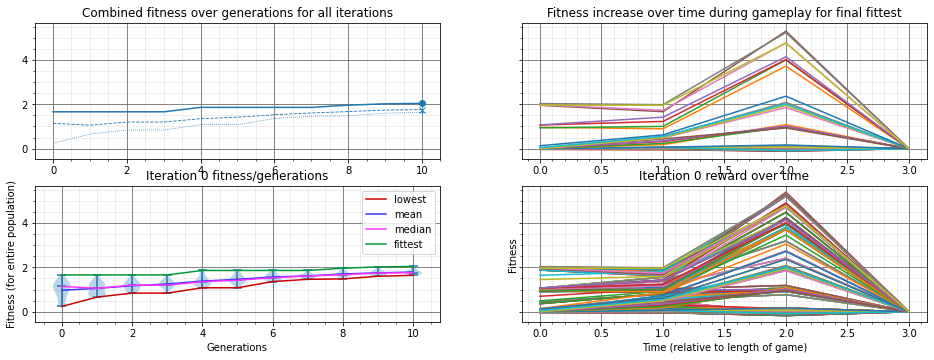

In [11]:
runner1.produce_graph(gens1).show()


In [49]:
class Chromosome4P(BaseChromosome):

    my_rules_list: ClassVar[Tuple[RulesEnum]] = RulesEnum.to_tuple()

    def __init__(
            self,
            p0: Optional[np.ndarray] = None,
            p1: Optional[np.ndarray] = None,
            p2: Optional[np.ndarray] = None,
            p3: Optional[np.ndarray] = None
    ):

        self._fitness: Optional[float] = None
        self._results: Optional[GameResults] = None

        self.chromosomes: Dict[int, np.ndarray] = {}

        if p0 is None:
            self.chromosomes[0]: np.ndarray = rng.random(len(self.my_rules_list))
        else:
            self.chromosomes[0]: np.ndarray = p0
        if p1 is None:
            self.chromosomes[1]: np.ndarray = rng.random(len(self.my_rules_list))
        else:
            self.chromosomes[1]: np.ndarray = p0
        if p2 is None:
            self.chromosomes[2]: np.ndarray = rng.random(len(self.my_rules_list))
        else:
            self.chromosomes[2]: np.ndarray = p0
        if p3 is None:
            self.chromosomes[3]: np.ndarray = rng.random(len(self.my_rules_list))
        else:
            self.chromosomes[3]: np.ndarray = p0

    def get_rules(self, inf: ChromosomeInfo) -> Iterator[RulesEnum]:
        return self.get_ordered_rules_iterator(
            self.chromosomes[inf.player_index], self.my_rules_list
        )


    @classmethod
    def generate_random(cls) -> "Chromosome4P":
        return cls()


    @classmethod
    def crossover(
            cls, p1: "Chromosome4P", p2: "Chromosome4P"
    ) -> "Chromosome4P":
        return cls(
            *(
                cls.lerper(
                    p1.chromosomes[i], p2.chromosomes[i],
                    rng.random(),
                    do_a_flip=rng.random() < 0.25
                ) for i in range(4)
            )
        )

    @classmethod
    def mutate(cls, p1: "Chromosome4P", mut_rate: float = 0.05) -> "Chromosome4P":
        return cls(
            *(
                p1.chromosomes[i] + (rng.random(len(cls.my_rules_list)) * mut_rate) % 1
                for i in range(4)
            )
        )

    @classmethod
    def shuffle(cls, p1: "Chromosome4P") -> "Chromosome4P":
        return cls(
            cls.shuffler(p1.chromosomes[0].copy()),
            cls.shuffler(p1.chromosomes[1].copy()),
            cls.shuffler(p1.chromosomes[2].copy()),
            cls.shuffler(p1.chromosomes[3].copy())
            )

    def _decode_a_chromosome(self, ind: int) -> str:
        return f"    player {ind}:\n" \
               f"        {self.chromosomes[ind]}\n" \
               f"        {tuple(r for r in self.get_ordered_rules_iterator(self.chromosomes[ind],self.my_rules_list))}"

    @property
    def _decode_all(self) -> str:
        dstr: str = ""
        for k in self.chromosomes.keys():
            dstr = dstr + f"{self._decode_a_chromosome(k)}\n"
        if dstr == "":
            return dstr
        return dstr[:-1]

    @property
    def decode(self) -> str:
        if self._fitness is not None:
            return f"decoded {self.__class__.__name__}:\n" + \
               f"  fitness:  {str(self._fitness)}\n" +\
               f"  chromosome\n" +\
               f"{self._decode_all}"
        return f"decoded {self.__class__.__name__}" +\
               f"  chromosome\n" +\
               f"{self._decode_all}"




In [50]:
runner2: GA_Runner = GA_Runner(Chromosome4P)


In [51]:

all_bests2: List[Chromosome4P] = []
all_gens2: List[List[GA_Runner.GenerationInfo]] = []

bests2, gens2 = runner2.run_the_GA(1, True)

all_bests2.append(*bests2)
all_gens2.append(gens2)
print(bests2[0].decode)


Commencing the thing!
Populating!... Populated! Starting fitness evaluations.
Fitness evaluations done!gen 0: decoded Chromosome4P:
  fitness:  1.8
  chromosome
    player 0:
        [0.40912306 0.7616408  0.01663749 0.31017537 0.46360324 0.05524914
 0.17579249 0.52452794 0.26123909 0.16341392 0.87697503 0.9795305
 0.1738319  0.58697591 0.92949985 0.74605242 0.89509067 0.87721614
 0.42142103 0.71257025 0.68644049 0.61172782 0.64365594 0.82117701
 0.78877299 0.61271912 0.719037   0.29916811 0.47790595 0.78129858
 0.45054079 0.24742407 0.05850831 0.82767152 0.92403269 0.75022653
 0.32158332 0.2910627  0.89117471 0.59677526 0.1208264 ]
        (<RulesEnum.TELL_PLAYER_ABOUT_FIVES_COLOR: 11>, <RulesEnum.TELL_PLAYER_ABOUT_PLAYABLE_ONES_RANK: 14>, <RulesEnum.TELL_PLAYER_ABOUT_OLDEST_UNKNOWN_CARD_IF_UNIQUE_VISIBLE_COLOR: 34>, <RulesEnum.TELL_PLAYER_ABOUT_USEFUL_TWOS_RANK: 16>, <RulesEnum.TELL_NEXT_PLAYER_ABOUT_OLDEST_UNKNOWN_CARD_IF_UNIQUE_VISIBLE_COLOR: 38>, <RulesEnum.TELL_PLAYER_ABOUT_USEFU

C:\Users\rl18730\AppData\Local\Temp/ipykernel_21476/1729563673.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  runner2.produce_graph(gens2).show()


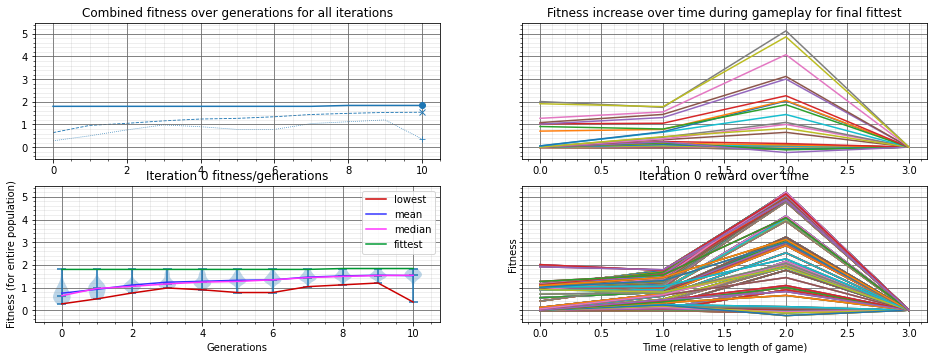

In [52]:
runner2.produce_graph(gens2).show()



In [45]:
class GamePhaseChromosome(BaseChromosome):

    early_game_rules: ClassVar[Tuple[RulesEnum]] = tuple(
        r for r in RulesEnum.to_tuple() if r not in {
            RulesEnum.TELL_NEXT_PLAYER_ABOUT_UNPLAYABLE_COLOR,
            RulesEnum.TELL_NEXT_PLAYER_ABOUT_UNPLAYABLE_RANK,
            RulesEnum.TELL_PLAYER_ABOUT_USELESS_RANK,
            RulesEnum.TELL_PLAYER_ABOUT_USELESS_COLOR
        }
    )
    """Rules for the 'early game', or, in other words, 'until someone decides to discard'
    or 'until there's only one life left'"""

    mid_game_rules: ClassVar[Tuple[RulesEnum]] = tuple(
        r for r in RulesEnum.to_tuple() if r not in {
            # again, trying to avoid confusion
            RulesEnum.TELL_NEXT_PLAYER_ABOUT_UNPLAYABLE_COLOR,
            RulesEnum.TELL_NEXT_PLAYER_ABOUT_UNPLAYABLE_RANK,
            RulesEnum.TELL_PLAYER_ABOUT_USELESS_RANK,
            RulesEnum.TELL_PLAYER_ABOUT_USELESS_COLOR
        }
    )
    "Rules between the early game and the realization of only having one life left"

    panic_rules: ClassVar[Tuple[RulesEnum]] = tuple(
        r for r in RulesEnum.to_tuple() if r not in {
            # trying to avoid misplays
            RulesEnum.PLAY_MOST_PLAYABLE_CARD_40,
            RulesEnum.PLAY_MOST_PLAYABLE_CARD_50,
            # trying to avoid causing confusion
            RulesEnum.TELL_NEXT_PLAYER_ABOUT_UNPLAYABLE_COLOR,
            RulesEnum.TELL_NEXT_PLAYER_ABOUT_UNPLAYABLE_RANK,
            RulesEnum.TELL_PLAYER_ABOUT_USELESS_RANK,
            RulesEnum.TELL_PLAYER_ABOUT_USELESS_COLOR
        }
    )
    "Rules for when 'im panicking theres only one life left'"


    def __init__(self, early: np.ndarray = None, mid: np.ndarray = None, late:np.ndarray = None):
        self._fitness = None
        self._results = None

        if early is None:
            self.early: np.ndarray = rng.random(len(self.early_game_rules))
        else:
            assert len(early) >= len(self.early_game_rules)
            self.early: np.ndarray = early[:len(self.early_game_rules)]

        if mid is None:
            self.mid: np.ndarray = rng.random(len(self.mid_game_rules))
        else:
            assert len(mid) >= len(self.mid_game_rules)
            self.mid: np.ndarray = mid[:len(self.mid_game_rules)]

        if late is None:
            self.late: np.ndarray = rng.random(len(self.panic_rules))
        else:
            assert len(late) >= len(self.panic_rules)
            self.late: np.ndarray = late[:len(self.panic_rules)]


    def get_rules(self, inf: ChromosomeInfo) -> Iterator[RulesEnum]:
        if inf.lives == 1:
            return self.get_ordered_rules_iterator(
                self.late, self.panic_rules
            )
        elif inf.has_discarded:
            return self.get_ordered_rules_iterator(
                self.mid, self.mid_game_rules
            )
        return self.get_ordered_rules_iterator(
            self.early, self.early_game_rules
        )


    @classmethod
    def generate_random(cls) -> "GamePhaseChromosome":
        return cls()


    @classmethod
    def crossover(
            cls, p1: "GamePhaseChromosome", p2: "GamePhaseChromosome"
    ) -> "GamePhaseChromosome":
        return cls(
            cls.lerper(
                p1.early, p2.early, rng.random(), do_a_flip=rng.random() < 0.25
            ),
            cls.lerper(
                p1.mid, p2.mid, rng.random(), do_a_flip=rng.random() < 0.25
            ),
            cls.lerper(
                p1.late, p2.late, rng.random(), do_a_flip=rng.random() < 0.25
            )
        )

    @classmethod
    def mutate(cls, p1: "GamePhaseChromosome", mut_rate: float = 0.05) -> "GamePhaseChromosome":
        return cls(
            p1.early + (rng.random(len(cls.early_game_rules)) * mut_rate) % 1,
            p1.mid + (rng.random(len(cls.mid_game_rules)) * mut_rate) % 1,
            p1.late + (rng.random(len(cls.panic_rules)) * mut_rate) % 1
        )

    @classmethod
    def shuffle(cls, p1: "GamePhaseChromosome") -> "GamePhaseChromosome":
        return cls(
            cls.shuffler(p1.early.copy()),
            cls.shuffler(p1.mid.copy()),
            cls.shuffler(p1.late.copy())
        )

    @property
    def _decode_all(self) -> str:
        return f"    early:\n" \
               f"      {self.early}\n" \
               f"      {[r for r in self.get_ordered_rules_iterator(self.early, self.early_game_rules)]}\n" \
               f"    mid:\n" \
               f"      {self.mid}\n" \
               f"      {[r for r in self.get_ordered_rules_iterator(self.mid, self.mid_game_rules)]}\n" \
               f"    late:\n" \
               f"      {self.late}\n" \
               f"      {[r for r in self.get_ordered_rules_iterator(self.late, self.panic_rules)]}" \


    @property
    def decode(self) -> str:
        if self._fitness is not None:
            return f"decoded {self.__class__.__name__}:\n" + \
               f"  fitness:  {str(self._fitness)}\n" +\
               f"  chromosome\n" +\
               f"{self._decode_all}"
        return f"decoded {self.__class__.__name__}" +\
               f"  chromosome\n" +\
               f"{self._decode_all}"

In [46]:
runner3: GA_Runner = GA_Runner(GamePhaseChromosome)


In [47]:

all_bests3: List[GamePhaseChromosome] = []
all_gens3: List[List[GA_Runner.GenerationInfo]] = []

bests3, gens3 = runner3.run_the_GA(1, True)

all_bests3.append(*bests3)
all_gens3.append(gens3)
print(bests3[0].decode)


Commencing the thing!
Populating!... Populated! Starting fitness evaluations.
Fitness evaluations done!gen 0: decoded GamePhaseChromosome:
  fitness:  1.28
  chromosome
    early:
      [0.78014483 0.84812922 0.95648281 0.85108107 0.23171472 0.22830698
 0.28832459 0.95626002 0.63752897 0.1305583  0.60541501 0.17053221
 0.17471139 0.25849222 0.76389659 0.39717643 0.28041675 0.53049041
 0.16891812 0.61653087 0.2511785  0.16444958 0.63315211 0.24054395
 0.4675547  0.17083958 0.73420003 0.03918213 0.40644442 0.25904531
 0.38465126 0.46040145 0.77046463 0.00673423 0.35869087 0.83428679
 0.30093998]
      [<RulesEnum.PLAY_MOST_PLAYABLE_CARD_60: 2>, <RulesEnum.DISCARD_OLDEST_UNKNOWN_CARD: 7>, <RulesEnum.PLAY_MOST_PLAYABLE_CARD_50: 3>, <RulesEnum.PLAY_MOST_PLAYABLE_CARD_80: 1>, <RulesEnum.TELL_NEXT_PLAYER_ABOUT_OLDEST_UNKNOWN_CARD_IF_ENDANGERED_RANK: 39>, <RulesEnum.PLAY_MOST_PLAYABLE_CARD_90: 0>, <RulesEnum.TELL_PLAYER_ABOUT_OLDEST_UNKNOWN_CARD_IF_ENDANGERED_COLOR: 36>, <RulesEnum.TELL_PLAYER

C:\Users\rl18730\AppData\Local\Temp/ipykernel_21476/1671060144.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  runner3.produce_graph(gens3).show()


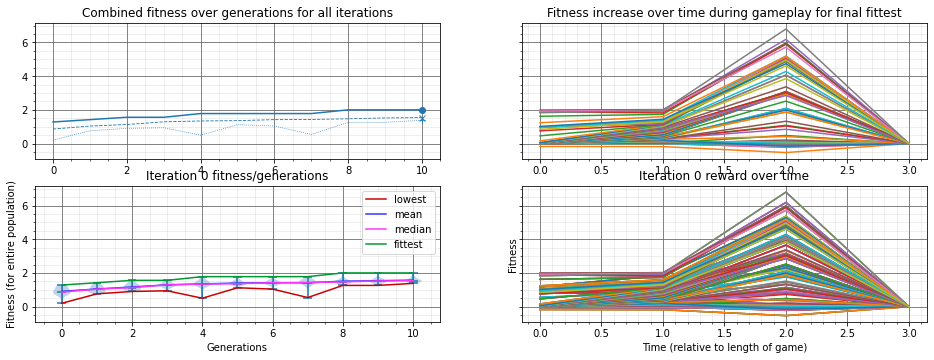

In [48]:
runner3.produce_graph(gens3).show()


In [ ]:
bests1, gens1 = runner1.run_the_GA(1, True)

all_bests.append(*bests1)
all_gens.append(gens1)
print(bests1[0].decode)

In [ ]:
runner1.produce_graph(gens1).show()

In [ ]:
bests1, gens1 = runner1.run_the_GA(1, True)

all_bests.append(*bests1)
all_gens.append(gens1)
print(bests1[0].decode)

In [ ]:
runner1.produce_graph(gens1).show()

In [ ]:
for b in bests1:
    print(b.decode)

print("\n\nBEST FOR 'ChromosomeThatIHopeWorks':")

best_v1: ChromosomeThatIHopeWorks = max(bests1)
print(best_v1.decode)

In [ ]:
bests2, gens2 = runner2.run_the_GA(1, True)

all_bests2.append(*bests2)
all_gens2.append(gens2)
print(bests2[0].decode)


In [ ]:
runner2.produce_graph(gens2).show()

In [ ]:

bests2, gens2 = runner2.run_the_GA(1, True)

all_bests2.append(*bests2)
all_gens2.append(gens2)
print(bests2[0].decode)


In [ ]:
runner2.produce_graph(gens2).show()


In [ ]:
for b in bests2:
    print(b.decode)

print("\n\nBEST FOR 'Chromosome4P':")

best_v2: Chromosome4P = max(bests2)
print(best_v2.decode)





In [ ]:
bests3, gens3 = runner3.run_the_GA(1, True)

all_bests3.append(*bests3)
all_gens3.append(gens3)
print(bests3[0].decode)


In [ ]:
runner3.produce_graph(gens3).show()

In [ ]:

bests3, gens3 = runner3.run_the_GA(1, True)

all_bests3.append(*bests3)
all_gens3.append(gens3)
print(bests3[0].decode)



In [ ]:
runner3.produce_graph(gens3).show()


In [ ]:
for b in bests3:
    print(b.decode)

print("\n\nBEST:")

best_v3: GamePhaseChromosome = max(bests3)
print(best_v3.decode)
